# Batch analysis of cosmic rays using Drift Tubes detectors

Group members:
- Bergamin Eleonora
- Boni Filippo
- Campagnola Stefano

## Introduction

The project aims to reconstruct to reconstruct the trajectories of muons colliding on four drift tubes detectors. This is done analyzing 81 files of binary records coming from Time-to-Digital Conversion of the cell electric signals. The size of each file is approximately 11MB leading to a dataset dimension of about 809MB.

Data processing is performed using Apache Spark distributed framework, running on a CloudVeneto cluster of virtual machines. In order to reduce the execution time of the analysis parallelizzation is essential: its effects will also be examined in relation to the cluster setup.

## Starting Cluster

Spark is known to have the Spark SQL module dedicated to storing and processing structured datasets (which are called Spark Dataframes); moreover, the module allows more optimized processing than that applicable to an RDD.
Since we will deal with structured data in our analysis, we chose Spark to perform our analysis.


The first step of the configuration is the setup of the cluster on CloudVeneto. To connect seamlessly from a personal machine and to efficiently manage port forwarding, a `.ssh/config` file is used.
The cluster is composed of three virtual machines that have 4 cores and 8 GB of memory, of which 6.8 available for use.
The first machine is used as master, whereas the two other machines are employed as workers, with a variable number of executors.

The total number of cores used, the memory per executor, and the number of cores assigned to each executor can be set during the creation of the Spark session and can be varied.
Since those parameters, together with the number of partitions of the Spark Dataframe, can be modified, performance analysis has been carried on below to find which configuration is optimal.


To practically create the cluster, the alias `startspark` is used: it starts the master node with the `start-master.sh` script and the worker nodes with the `start-workers.sh`. To stop the Spark execution in the master and worker nodes using `stop-all.sh`, the `stopspark` command is used.

In [1]:
import findspark
findspark.init('/usr/local/spark')

In [1]:
import struct
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as f
from pyspark.sql.functions import when, col, lag, lit, atan
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, FloatType
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from math import log
from IPython.display import display, Math, Markdown, Latex
from itertools import product
import itertools
import pyspark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from pyspark.sql.functions import pandas_udf, PandasUDFType, round
from matplotlib.patches import Rectangle
import matplotlib
matplotlib.rcParams.update({'figure.max_open_warning': 0})

In [ ]:
sc.stop()

In [ ]:
spark.stop()

In [3]:
spark = SparkSession.builder \
    .master("spark://10.67.22.54:7077")\
    .appName("Batch analysis project")\
    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-common:3.3.1')\
    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.3.1')\
    .config('spark.jars.packages', 'com.amazonaws:aws-java-sdk:1.11.375')\
    .config("spark.executor.cores", 4)\
    .config("spark.executor.memory", "6400m")\
    .config("spark.sql.shuffle.partitions", 64)\
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
    .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')\
    .config('spark.hadoop.fs.s3a.access.key', 'bd1d38ce96d7476eb45eacafd4d8f772')\
    .config('spark.hadoop.fs.s3a.secret.key', '123bd7b3d07f493e81f38df47e871a78')\
    .config('spark.hadoop.fs.s3a.endpoint', 'https://cloud-areapd.pd.infn.it:5210')\
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.metadatastore.impl", "org.apache.hadoop.fs.s3a.s3guard.NullMetadataStore") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled","false") \
    .config("com.amazonaws.sdk.disableCertChecking","true") \
    .getOrCreate()

:: loading settings :: url = jar:file:/usr/local/spark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.amazonaws#aws-java-sdk added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-836a1bbb-69ab-48ea-8c70-41dbac670eb0;1.0
	confs: [default]
	found com.amazonaws#aws-java-sdk;1.11.375 in central
	found com.amazonaws#aws-java-sdk-dlm;1.11.375 in central
	found com.amazonaws#aws-java-sdk-core;1.11.375 in central
	found commons-logging#commons-logging;1.1.3 in central
	found org.apache.httpcomponents#httpclient;4.5.5 in central
	found org.apache.httpcomponents#httpcore;4.4.9 in central
	found commons-codec#commons-codec;1.10 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found com.fasterxml.jackson.core#jackson-databind;2.6.7.1 in central
	found com.fasterxml.jackson.core#jackson-annotations;2.6.0 in central
	found com.fasterxml.jackson.core#jackson-core;2.6.7 in central
	found com.fasterxml.jackson.dataformat#jackson-dataformat-cbor;2.6.7 in

In [4]:
sc = spark.sparkContext
sc

<SparkContext master=spark://10.67.22.54:7077 appName=Batch analysis project>

## Preprocessing

In this section, the aim is to convert a bunch of binary files into a structured pySpark Dataframe, which will be processed later. Data processing will follow this pipeline:
- first, the binary files will be gathered in an RDD and decoded in parallel using the `map` operation; 
- secondly, the inner structure of the records will be used to create a structured pySpark Dataframe
- finally, some filtering will be needed to preserve only the physically interpretable events.

### Dataset import and decoding

The dataset is composed of multiple binary files encoding the stream of hits collected:
-  Every hit is encoded as a 64bit word
-  Each word has the exact same structure

The dataset is imported as RDD through the use of the function `binaryRecords`, which allows splitting every binary string into pieces of 8 bytes (64 bit) each.

In [5]:
import time
start_time = time.time()

In [6]:
rdd = spark.sparkContext.binaryRecords('s3a://mapd-minidt-batch/data_*.dat', 8)

22/09/03 20:43:06 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [7]:
rdd = rdd.repartition(64)

Note that a `repartition()` transformation is applied: if not applied, the number of partitions after loading would correspond to the number of loaded files, in our case 81.

Also, we use `repartition()` instead of `coalesce()`. As will be explained in detail below, sometimes during its tuning the number of partitions has to be increased from its default value set after loading the files (81).

Increasing the number of partitions can only be done with `repartition()`. To run all the tests with the same code and conditions, we chose to always use `repartition()`, even if that implies a full shuffle of the data.

The 64b data-format complies to the following standard:

- 0-4 (5 bits) $\rightarrow$ TDC
- 5-16 (12 bits) $\rightarrow$ BX
- 17-48 (32 bits) $\rightarrow$ ORBIT
- 49-57 (9 bits) $\rightarrow$ CHAN
- 58-60 (3 bits) $\rightarrow$ FPGA
- 61-63 (3 bits) $\rightarrow$ HEAD

Each entry of the RDD can be mapped to an `np.array` of 6 integers using a custom decoding function, described as follows.

In [8]:
def decoding(words):
    
    words = int.from_bytes(words, "little") # If byteorder is "little", the most significant byte is at the end of the byte array
    data=np.zeros(6, dtype='u4') # unsigned integer of 4 bytes
    data[0] = words & 0x1F # TDC
    data[1] = words >> 5  & 0xFFF # BX
    data[2] = words >> 17 & 0xFFFFFFFF # ORBIT
    data[3] = words >> 49 & 0x1FF # CHAN
    data[4] = words >> 58 & 0x7 # FPGA
    data[5] = words >> 61 & 0x7 # HEAD
        
    return data

In [9]:
rdd2 = rdd.map(decoding)

To convert the whole dataset to a pySpark Dataframe, one last step is taken: each array is transformed into a list and applying the `toDF()` method.

In [10]:
df = rdd2.map(lambda x: x.tolist()).toDF(["TDC", "BX", "ORBIT", "CHAN", "FPGA", "HEAD"])

### Selection of the meaningful hits

To discard ancillary data that do not contain any information on the hits, only the measurements indexed by *HEAD* = 2 and whit *CHAN* $\leq$ 128 are preserved in the Dataframe. 

In [11]:
df0 = df[(df['HEAD'] == 2) & (df['CHAN'] <= 128)]

A priori, it is difficult to recognize which information belongs to the same physical event as a muon detection. For this reason, it is necessary to make some assumptions:

- the detection of muons is a "rare" event, in the sense that in 1 *ORBIT* (25 ns) on average only muon passage is expected. So, from now on, a specific value of *ORBIT* is interpreted as a single event. For example, grouping on *ORBIT* means grouping hits belonging to the same event.


- An event can have exactly one scintillator hit associated with it ($n_{scint} = 1$), which can be recognized by the values of *CHAN* = 128 and *FPGA* = 1. This is because multiple scintillator activations would lead to some ambiguity in the calculation of $t_0$. Orbits that have $n_{scint} \neq 1$ must therefore be discarded.


- In order to provide meaningful information, an *ORBIT* must have a number of hits $n_{hits}$ that is in the range $4 \leq n_{hits} \leq 17$. Considering the case when an *ORBIT* has just one scintillator hit associated with it, the remaining hits can be at minimum $3$ (minimum number of points for a linear fit) and not more than $16$, meaning that all layers of all the chambers will detect one hit.

The next step is then to filter the dataset according to these assumptions. This is done practically by joining the dataset to its grouped version, obtained by aggregating each *ORBIT* and computing $n_{hits}$ and $n_{scint}$. It can be noticed that a multiple aggregation syntax has been used to improve the time performance.

In [12]:
from pyspark.sql import functions
 
df0 = df0.withColumn("scint", when((df0.FPGA == 1) & (df0.CHAN == 128), 1)\
                                  .otherwise(0))

feature_group = ['ORBIT']
data_counts = df0.groupBy(feature_group).agg(functions.count('ORBIT'), functions.sum('scint'))\
                .withColumnRenamed("count(ORBIT)", "n_hits")\
                .withColumnRenamed("sum(scint)", "n_scint")
# n_hits includes also scintillator hits

In [13]:
df1 = df0.join(data_counts, feature_group)

In [14]:
df1 = df1[(df1['n_hits'] < 18) & (df1['n_hits'] > 3) & (df1['n_scint'] == 1)]\
        .drop('scint','n_hits','n_scint')

## Time and space analysis of the events

### Time evaluation of the hits

Scintillatory hits, which enclose the informations about $t_0$, have the same same *ORBIT* value of the other hits not related to the scintillator. Thus, it is possible to compute the absolute time $t$ of a specific hit without considering its *ORBIT* value. 

\begin{equation}
    t = 25 \cdot \left(\mbox{BX} + \frac{1}{30} \mbox{TDC}\right)
\end{equation}

For a specific event with a certain *ORBIT* value, then, $t_0$ will be the absolute time $t$ of the hit with *CHAN* = 128.

To enter the time values in the Dataframe, new columns are added using `withColumn()`, and the irrelevant columns are dropped using the `drop()`. There operations will be widely used throughout the notebook.

In [15]:
df2 = df1.withColumn("t", col("BX")*25 + col("TDC")*(25/30))\
         .withColumn("t0", col("ORBIT")*0.0)\
         .drop('BX','TDC','HEAD')

The value of $t_0$ needs to be computed for every *ORBIT*. Hence, every row with the same value of *ORBIT* is identified as a *group*.

For each group the value of $t$ corresponding to *CHAN = 128* is found and labeled as $t_0$.

These operations are summarized in the `compute_t0` function, acting on every single group using the `applyInPandas` method ([link](https://https://spark.apache.org/docs/3.2.0/api/python/reference/api/pyspark.sql.GroupedData.applyInPandas.html)). The schema of the injected Dataframe needs to be specified a priori.

In [16]:
def compute_t0(group):
    
    t0 = group[group.CHAN == 128].t.values
    
    group['t0'] = np.repeat(t0, group.shape[0])
  
    return group

In [17]:
schema = "ORBIT int, CHAN int, FPGA int, t double, t0 double"
df3 = df2.groupBy("ORBIT").applyInPandas(compute_t0, schema)

Two new columns are then created for each event: `CHAMBER` and` LAYER`. These columns describe where the event occurs. As can be seen from the image below, each chamber is divided into 4 layers. Adjacent layers are staggered by half of a cell width.

Each chamber also consists of 64 channels, while channel 128 corresponds to the scintillator.
When a channel records a hit, this channel is said to be activated.

From the *CHANNEL* and *FPGA* information, the number of the chamber for a specific hit can be retrieved by the following rule:

-  If *FPGA* = 0 and 0 $\leq$ *CHANNEL* $\leq$ 63, the hit belongs to chamber 0
-  If *FPGA* = 0 and 64 $\leq$ *CHANNEL* $\leq$ 127, the hit belongs to chamber 1
-  If *FPGA* = 1 and 0 $\leq$ *CHANNEL* $\leq$ 63, the hit belongs to chamber 2
-  If *FPGA* = 1 and 64 $\leq$ *CHANNEL* $\leq$ 127, the hit belongs to chamber 3

Scintillator hits will have `Null` value for the chamber.

Layers can be computed, instead, from the pattern showed on the image below, which can be translated in a more or less complex formula.

![alt text](detector.png "Title")

In [18]:
df4 = df3.withColumn("CHAMBER", when(df3['CHAN']<128, 2*col('FPGA')+(col('CHAN')/64).astype('int')))\
         .withColumn("LAYER",(4-col('CHAN')%4) + ((((col('CHAN')%4)%3)/2).astype('int') - (((col('CHAN')%4)%3)%2)))\
         .drop('FPGA')

The time interval $dt$ is calculated. This is obtained for each row as the difference between $t$ and $t_0$, to which a global time offset of 95 ns must be added, due to the scintillator activation delay. A further offset, specific for each chamber, is then added to the sum to give the final measurement.

In [19]:
time_offset = np.array([-1.1, 6.4, 0.5, -2.6]) # time offset in ns for each chamber

In [20]:
df4 = df4.withColumn("dt", when((df4.CHAMBER == 0), col("t") - col("t0") + 95 + time_offset[0])\
                                 .when((df4.CHAMBER == 1), col("t") - col("t0") + 95 + time_offset[1])\
                                 .when((df4.CHAMBER == 2), col("t") - col("t0") + 95 + time_offset[2])\
                                 .when((df4.CHAMBER == 3), col("t") - col("t0") + 95 + time_offset[3])
                    )\
         .drop('t','t0')

Physical values needed for the calculations are initilized in the next piece of code. $L$ and $h$ are, respectively, the width and the height of a single cell. The vertical position of each chamber is collected in a list. Lastly, the drift velocity of the electron cloud is called $v_d$. The units of measure considered are specified in the comments.

In [21]:
L = 42 # mm
h = 13 # mm
z_0 = np.array([219.8, 977.3, 1035.6, 1819.8]) # mm
vd = (53.8)/1000 # mm/ns

Since the electron travel time cannot be negative or greater than the time to reach the end of the cell, negative values of $ dt $ or values greater than $ L / (2 v_d) $ must be discarded.

In [22]:
df4 = df4.filter((df4["dt"] > 0) & (df4["dt"] < L/(2*vd)))

### Cells location and right/left ambiguity

To retrieve the distance of the hit from the center of the activated channel and the position where the hit occurs, it is possible to use the drift velocity $v_d$ and the time interval $dt$.

But, even by exploiting the available information, it is not possible to understand whether the event occurs to the left or to the right of the center of the channel. This problem, called left / right ambiguity, will be solved later, after obtaining other information useful for its calculation.

Indeed, it is useful to calculate the position of the center of each active channel ($x_c$) and its height ($z$).
The value of $x_c$ is obtained from the following setps: 

1. the channel number is considered. Channels that have a value between 64 and 127 are subtracted a value of 64. 


2. the channel number is divided by a factor of 4 and only the integer part of the result is considered. The obtained value is multiplied for the length of the channel $L$.


3. if the layer associated to the channel is equal to 1 or 3, a value of $L$ is added; if, on the other hand, the layer associated to the channel is equal to 2 or 4 a value of $L/2$ is added.

The value of *z* depends on the chamber and on the layer. It is calculated as follows: 

1. the height of the channel is the height of layer. It is calculated by multiplying the layer value and the height of a single channel.


2. To obtain the height of the cell center, a value of $h/2$ is subtracted.


3. Each chamber is associated with an offset in height since each chamber is placed at a different height. The final value of $z$ is obtained by adding the offset, which is different for the chamber, to the result of the previous operations.

In [23]:
df4 = df4.withColumn("x_c", (((col('CHAN')-((col('CHAN')/64).astype('int'))*64)/4).astype('int'))*L + (col('LAYER')%2)*L + (1 - (col('LAYER')%2))*(L/2))\
         .withColumn("z", when((df4.CHAMBER == 0), (col('LAYER') - 0.5)*h + z_0[0])\
                                 .when((df4.CHAMBER == 1), (col('LAYER') - 0.5)*h + z_0[1])\
                                 .when((df4.CHAMBER == 2), (col('LAYER') - 0.5)*h + z_0[2])\
                                 .when((df4.CHAMBER == 3), (col('LAYER') - 0.5)*h + z_0[3]))

As explained above, it is not possible to understand if the event occurs to the left or to the right of the center of the channel. So now the two possible values are calculated for each row. The two values are calculated as follows:

- the left value $x_l$ : $x_c$ - $v_d$$\cdot$$dt$
- the right value $x_r$ : $x_c$ + $v_d$$\cdot$$dt$

In [24]:
df4 = df4.withColumn("x_l", col('x_c') - vd*col('dt'))\
            .withColumn("x_r", col('x_c') + vd*col('dt'))\
            .drop('dt')

## Local linear fit 

At this stage the left/right ambiguity is not resolved, and two possible hit positions (e.g. XLEFT, XRIGHT) are assigned to each hit.

The left/right ambiguity is solved by performing a local linear fit for each chamber: in this way the most probable configuration of left/right hits is found. The method is explained in detail in this section.


Each chamber is characterized by a certain number of active channels, therefore a number of hits, each hit subjected to left and right ambiguity. Thus, it is necessary to understand, for each hit, which of its two possible positions is the most probable.

This is done by considering all the possible combinations of positions of the hits within the same chamber. It is easy to understand that, if the number of active channels per chamber related to one event is 4, the maximum number of combinations is 16.

Four is not a random number. Assuming that the muon trajectories are approximately straight, the maximum number of active channels per chamber related to one event is 4, since the hits in the same chamber must be spatially close to each other.

For each combination of points, a least squared error linear fit is performed. The final combination of points is the one associated with the fit with the smallest sum of the squared residuals. Finally, the best combination of x values is saved as the angular coefficient $m$, the intercept $q$ and the value of a posterior uncertainty $sigma$.

The a posterior uncertainty $sigma$ is defined as follows:

\begin{equation}
\sigma_{post} = \sqrt{\frac{ssr}{n-2}}
\end{equation}

where $ssr$ is the sum of the squares of the residuals.

It is important to specify that the fits are performed considering the $x$ positions in the channel as dependent variables on the y-axis, and the $z$ values as independent variables on the x-axis. In general, when performing a fit, only the uncertainty on the y-axis is taken into account, so it is good practice to use the values with the smallest possible or negligible error as x-axis values: in this specific case, z is given, and not measured, so no error is associated to it, making it a good independent variable.

The discussed kind of fit is applied, for each chamber, to every event identified by a specific value of orbit.

Thus, to prepare the data for the linear fits, it will be grouped by orbit and then by chamber. This is performed using `applyInPandas` associated with a `groupBy(ORBIT, CHAMBER)`, similar for the computation of $t_0$.

The fits then will be performed by the `local_fit` function.
Inside it, three filters are additionally applied to the grouped hits. These filters are needed to discard events that are not easily manageable from the point of view of a linear fit, or do not have a clear physical interpretation.

The conditions applied by the filters are the following:

1. There must be at least 3 hits in 3 different layers. This filter allows performing a linear fit correctly using at least three points.


2. Each layer must be present no more than 1 time in the group of hits. This is to avoid multiple measurements in the same channel, which have no physical significance or correspond to different events.


3. Each active channel cannot be too far from the other active channels in the chamber. No jumps greater than $L/2$ from one cell and its neighborhood are allowed.

Events that do not respect the previous conditions will have each entry of the Dataframe set to a dummy value ($-1$), since the `applyInPandas` method cannot return anything other than a `pandas.DataFrame`. Deleting these events will then be forced manually by filtering the positive entries.

In [25]:
df5 = df4.withColumn("final_x", col("ORBIT")*0.0)\
         .withColumn("m", col("ORBIT")*0.0)\
         .withColumn("q", col("ORBIT")*0.0)\
         .withColumn("sigma", col("ORBIT")*0.0)  

In [26]:
def local_fit(group):
    sort_index = np.argsort(group['LAYER'])
    sort_x_c = np.array(group.x_c.values)[sort_index] # np.array
    if (group['LAYER'].nunique() > 2) and (group['LAYER'].nunique() == group.shape[0]) and (not (any(np.abs(np.diff(sort_x_c)) > (L/2)))):

        
        xl_val = np.asarray(group.x_l.values)

        xr_val = np.asarray(group.x_r.values)
        
        y = np.asarray(group.z)
        
        n = group.shape[0]

        l = [np.asarray([xl_val[i],xr_val[i]]) for i in range(n)]

        if n == 3:
            comb = np.array(np.meshgrid(l[0], l[1], l[2])).T.reshape(-1, n)
        if n == 4:
            comb = np.array(np.meshgrid(l[0], l[1], l[2], l[3])).T.reshape(-1, n)

        top_score = 100000 
        final_i=0
        m=0
        q=0

        for i in range(0,len(comb)):

            x=comb[i]
            y=y
            z,res,_,_,_ = np.polyfit(y, x, 1,full=True)

            score = res

            if score<top_score:

                final_i = i
                m = 1/z[0]
                q = -z[1]/z[0]
                top_score = score



        group['final_x'] = comb[final_i]
        group['m'] = np.repeat(m, group.shape[0])
        group['q'] = np.repeat(q, group.shape[0])
        group['sigma'] = np.repeat(np.sqrt(top_score/(n-2)), group.shape[0]) # a posterior sigma 

        return group
    
    else:
        
        return pd.DataFrame({
    'ORBIT': [-1],
    'CHAMBER': [-1],
    'LAYER': [-1],
    'CHAN': [-1],
    'x_c': [-1],
    'x_l': [-1],
    'x_r': [-1],
    'z': [-1],
    'final_x': [-1],
    'm': [-1],
    'q': [-1],
    'sigma': [-1]
    
    })

In [27]:
schema = "ORBIT int, CHAN int, CHAMBER int, LAYER int, x_c double, z double, x_l double, x_r double, final_x double, m double, q double, sigma double"
df10 = df5.groupBy("ORBIT","CHAMBER").applyInPandas(local_fit, schema)

In [28]:
df10 = df10[df10['LAYER']>0]

Considering the large number of operations performed in the previous steps, a `persist()` (and thus the `count()` action) is used to cache the data, in order to speed up the computation for future actions, since now the dataset is small enough to fit in the available memory.

In [29]:
df10 = df10.persist()

In [30]:
df10.count()

418657

In [31]:
col_names = ['ORBIT','CHAN','CHAMBER','LAYER','z','final_x','m','q','sigma']
df10.select([round(c,3).alias(c) for c in col_names]).show(20)

+-------+----+-------+-----+------+-------+------+----------+-----+
|  ORBIT|CHAN|CHAMBER|LAYER|     z|final_x|     m|         q|sigma|
+-------+----+-------+-----+------+-------+------+----------+-----+
|1144838|  42|      2|    3|1068.1|465.389|34.766|-15100.975|0.282|
|1144838|  43|      2|    1|1042.1|464.358|34.766|-15100.975|0.282|
|1144838|  44|      2|    4|1081.1|465.309|34.766|-15100.975|0.282|
|1144838|  45|      2|    2|1055.1|464.502|34.766|-15100.975|0.282|
|1316967|  48|      2|    4|1081.1|526.148| 8.614| -3454.058|0.424|
|1316967|  49|      2|    2|1055.1|523.449| 8.614| -3454.058|0.424|
|1316967|  47|      2|    1|1042.1|521.781| 8.614| -3454.058|0.424|
|1316967|  50|      2|    3|1068.1|525.439| 8.614| -3454.058|0.424|
|1365030| 109|      1|    2| 996.8|475.976|-2.837|  2348.489|0.562|
|1365030| 107|      1|    1| 983.8|481.309|-2.837|  2348.489|0.562|
|1365030| 108|      1|    4|1022.8|467.412|-2.837|  2348.489|0.562|
|1373389|  38|      2|    3|1068.1|428.276|-3.76

In [32]:
def plot_local_fit(event) : # event must contain a single orbit AND a single chamber
    fig, ax = plt.subplots(figsize = (25, 1.875)) 

    x_rect = np.arange(16)*L
    z_rect = np.arange(4)*h
    
    # set lim is important, if not present nothing is plotted
    ax.set_xlim(-h, L*16 + L)
    ax.set_ylim(-h, h*4 + h)
    
    for i in range(4):
        if i % 2 == 0:
            x = x_rect + L/2
        else:
            x = x_rect
        for j in range(16):
            ax.add_patch(Rectangle((x[j], z_rect[i]), L, h, lw = 2, edgecolor = 'black', facecolor = 'none'))
            ax.axis('off')
    
    xr, xl, z = event.x_r, event.x_l, event.z.to_numpy() - z_0[event.CHAMBER.iloc[0]]
    m, q = event.m.iloc[0], event.q.iloc[0] - z_0[event.CHAMBER.iloc[0]]
    
    ax.scatter(xr, z, c = "blue" , s = 50, linewidth = 1, label = 'x_r') 
    ax.scatter(xl, z, c = "blue" , s = 50, linewidth = 1, label = 'x_l') 
    
    xb = event.final_x.to_numpy()
    ax.scatter(xb, z, c = "red", s = 50, linewidth = 1, label = 'final_x')
    
    zmin = -h
    zmax = 4*h+h

    ax.plot([(zmin - q)/m, (zmax - q)/m], [zmin, zmax], 'g--', label = 'local fit', linewidth = 3)
        
    ax.set_title(f'orbit {event.ORBIT.iloc[0]}, chamber {event.CHAMBER.iloc[0]}, sigma = {event.sigma.iloc[0]:.3f}', fontsize = 20)
    ax.legend(loc = 'upper left', fontsize = 15)
    return ax


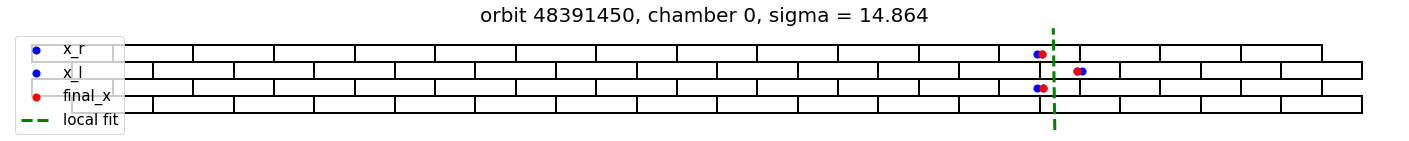

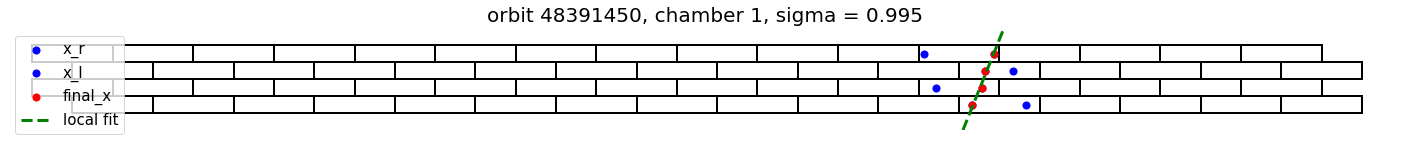

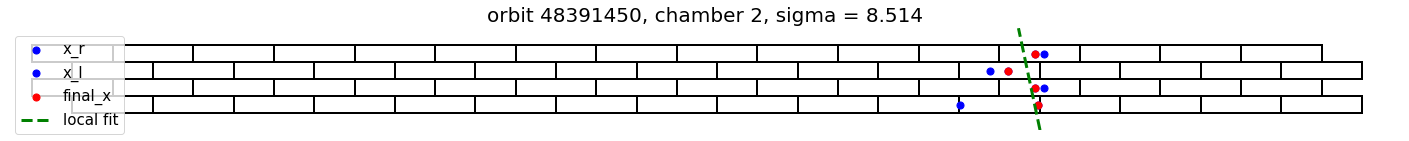

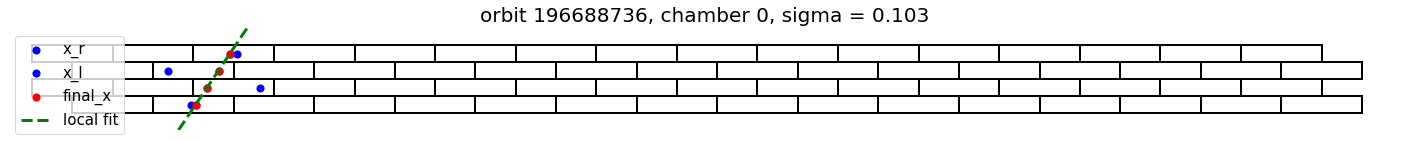

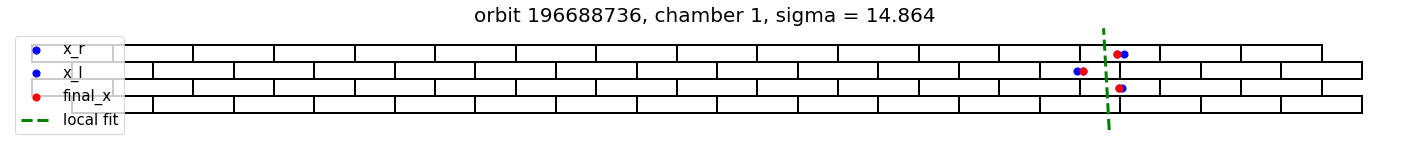

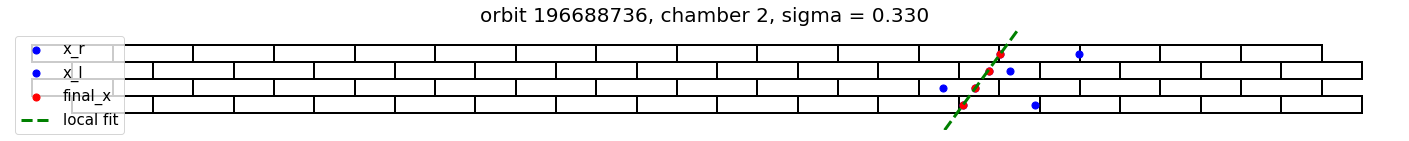

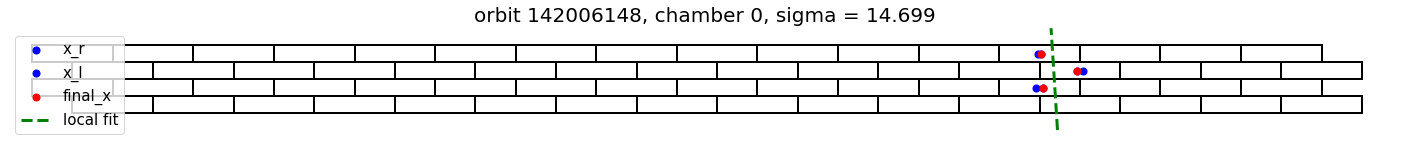

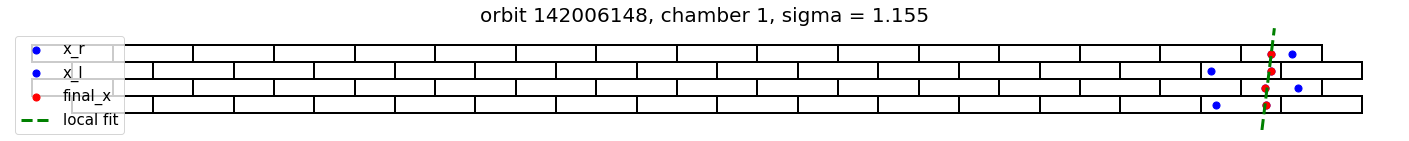

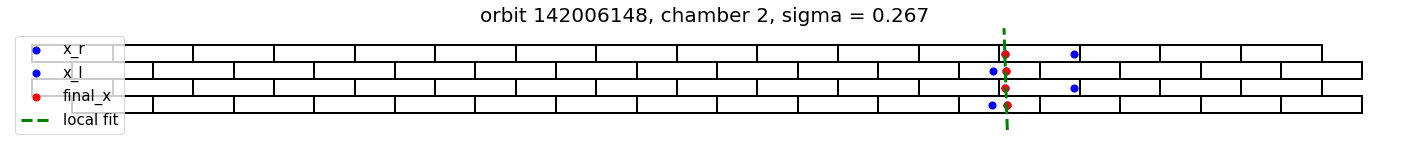

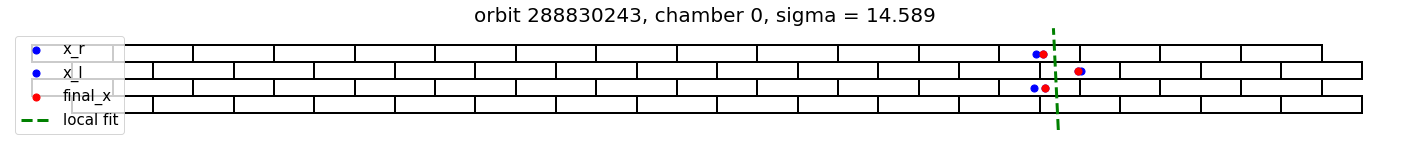

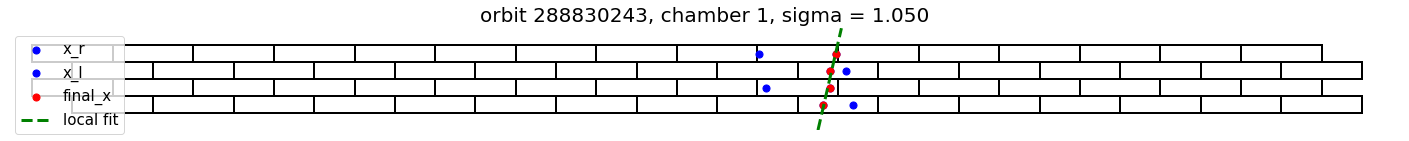

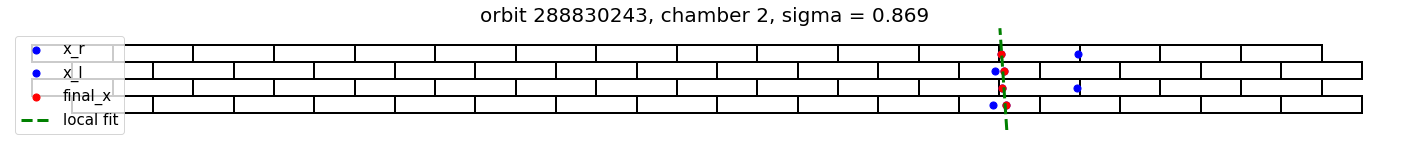

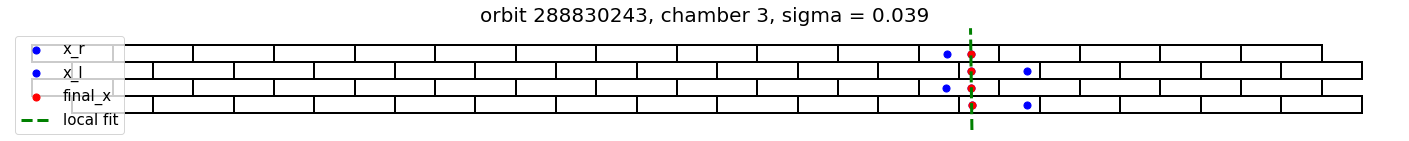

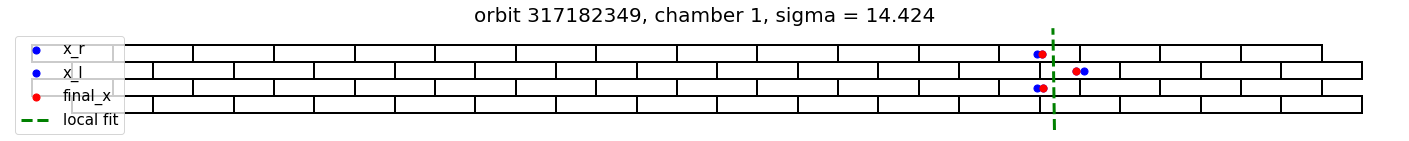

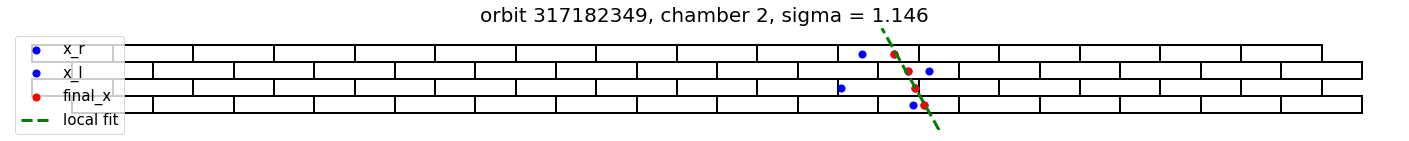

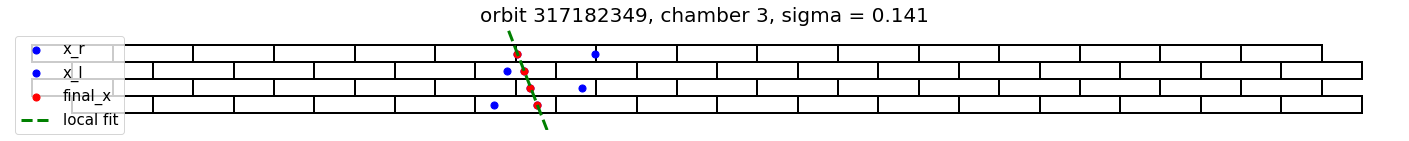

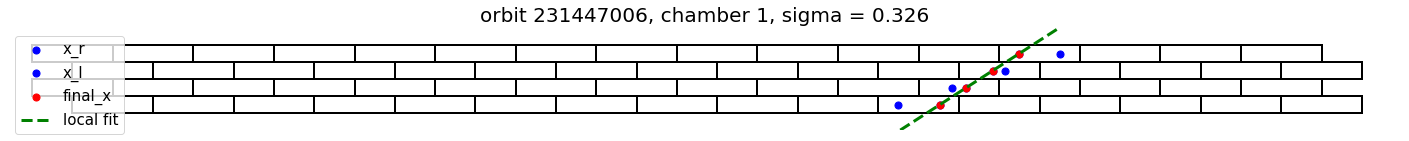

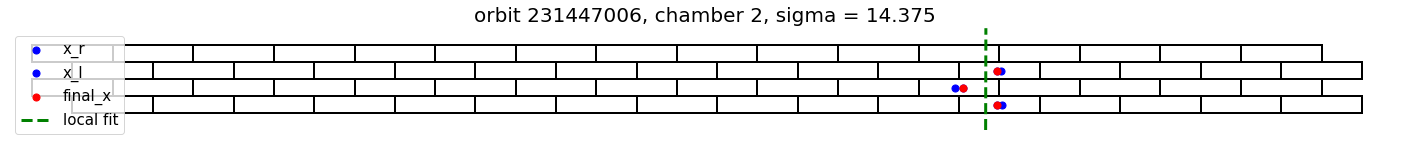

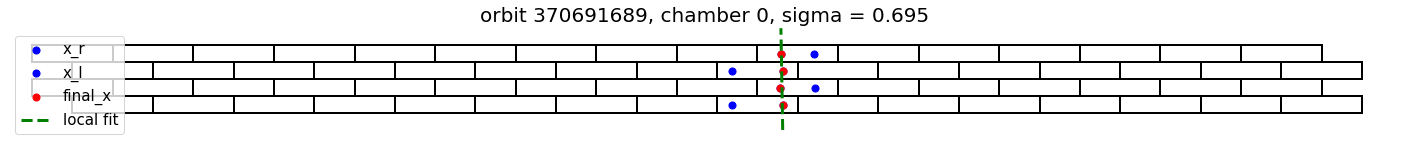

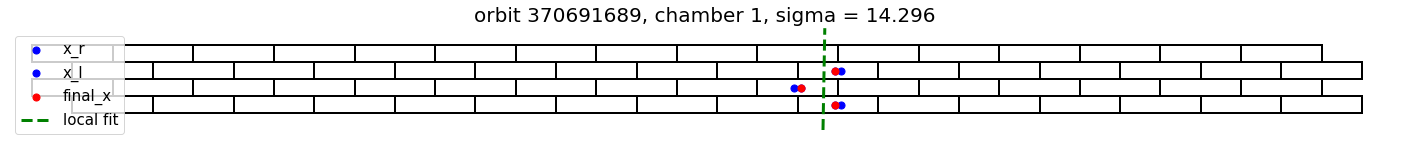

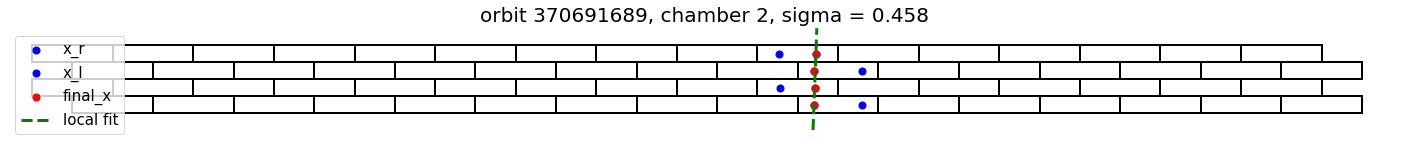

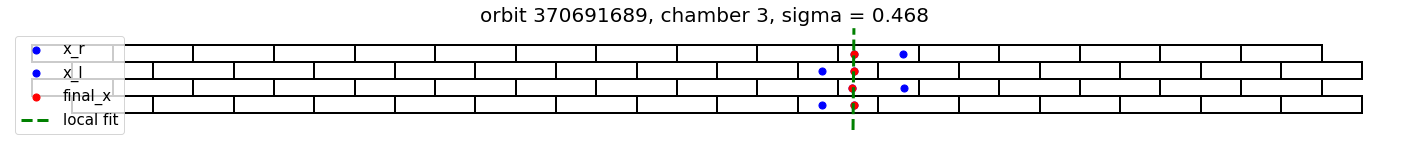

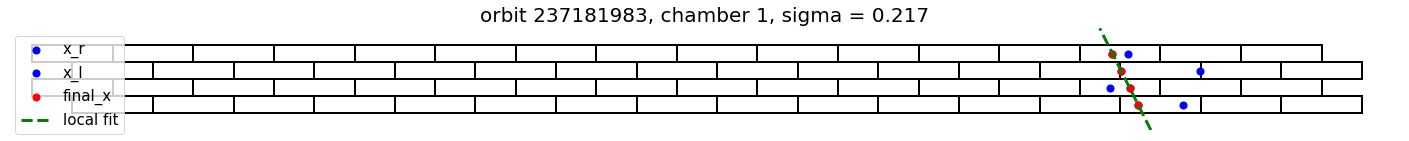

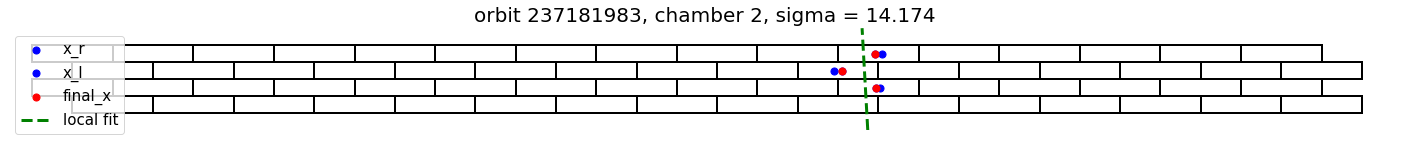

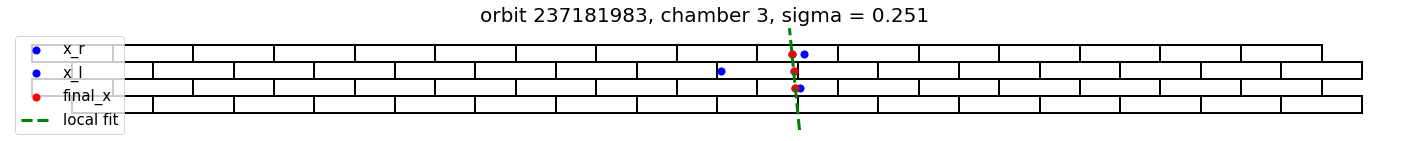

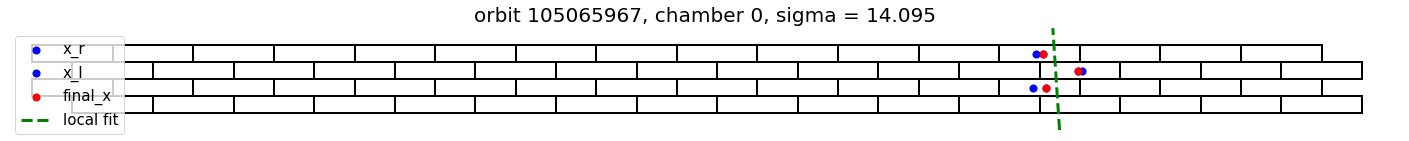

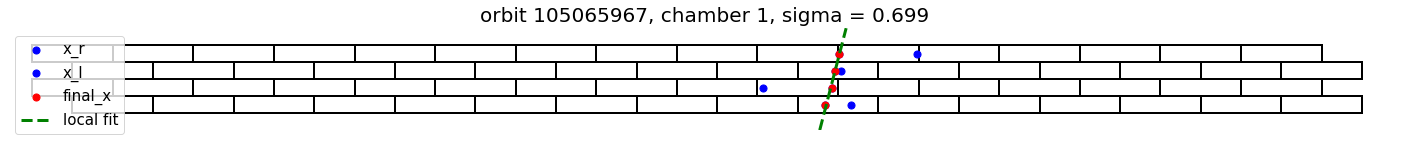

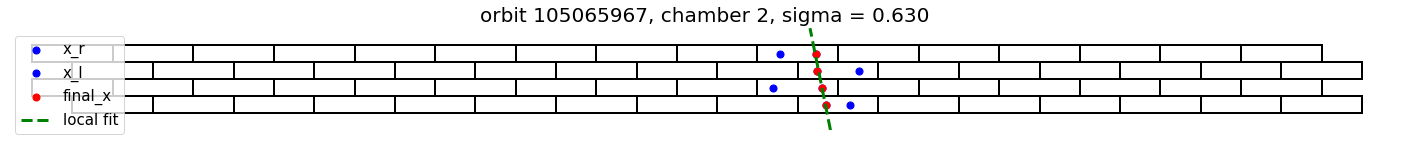

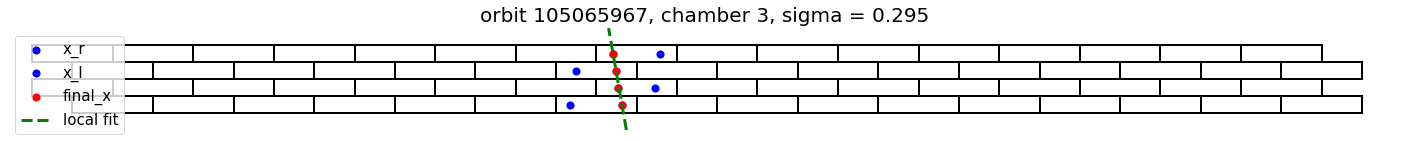

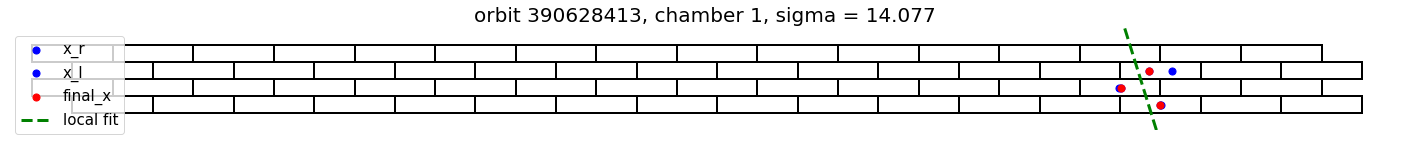

In [33]:
unique_orbits = [i.ORBIT for i in df10.select('ORBIT').distinct().orderBy(['sigma'], ascending=False).collect()] # order by chamber?
for orbit in unique_orbits[:10]:
    tmp = df10[df10.ORBIT == orbit].toPandas()
    for ch in np.sort(tmp.CHAMBER.unique()):
        plot_local_fit(tmp[tmp.CHAMBER == ch])

An interesting quantity to study for all the events is $sigma$, which holds information regarding the hit position uncertainty. Its distribution, as can be seen below, is peaked around 0.5 mm and gradually decreases as $sigma$ increases.

In [34]:
sigma_distr = np.array(df10.select('sigma').distinct().collect()).flatten()

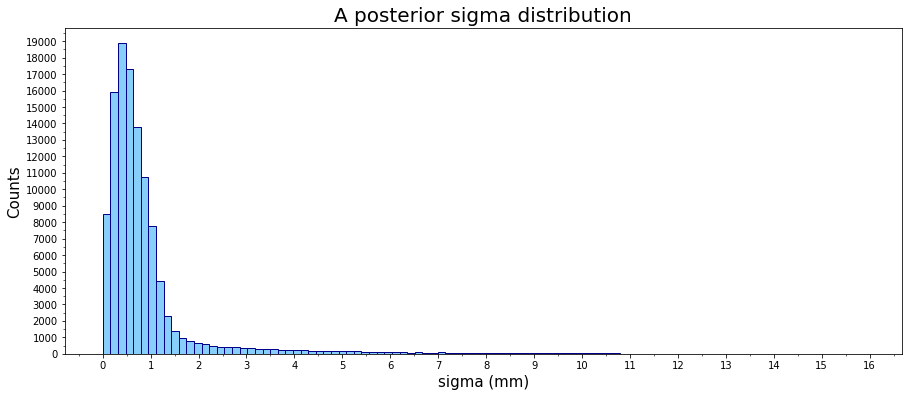

In [35]:
fig, ax = plt.subplots(figsize = (15, 6)) 
sigma_hist = ax.hist(sigma_distr, bins = 100, color='lightskyblue', edgecolor="darkblue", alpha=1)

ax.set_xlabel('sigma (mm)', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.set_title("A posterior sigma distribution", fontsize=20)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.yaxis.set_major_locator(MultipleLocator(1000))
ax.yaxis.set_minor_locator(MultipleLocator(500))

In [36]:
print("Mean value of a posterior sigma:", f'{np.round(np.mean(sigma_distr), 3)} mm')

Mean value of a posterior sigma: 0.895 mm


Having computed $ sigma $ for the different events, it can be seen that the average value is close to 1 mm, which is a reasonable value taking into account that the width of a cell is $ L $ = 42 mm.

## Global linear fit

Once the left and right ambiguity is solved, the hits are univocally placed. It is therefore possible, for each event, to estimate its global trajectory through each chamber by means of a least square linear fit.

The fit is performed for each event considering all the hits associated with it in all chambers, i.e., the fit is performed on hits that have same orbit value.

In practice, a `groupBy(ORBIT)` and a custom function are used to do this. The angular coefficient $m$, the intercept $q$ and the value of the a posterior uncertainty $sigma$ are saved in new columns of the Dataframe.

The functions used within the custom function to find the fit parameters are the same as those used for local fits. The considerations regarding the errors and therefore which quantities to place on the x and y axes are similar to what was discussed in the previous part concerning local fits.

In addition, a new filter is applied to each group of hits: there must be at least two active chambers in order to perform a global fit.

Events that do not meet the above conditions will be dropped in the same way as in the local fit case.

In [37]:
df11 = df10.withColumn("m_global", col("final_x")*0.0)\
           .withColumn("q_global", col("final_x")*0.0)\
           .withColumn("sigma_global", col("final_x")*0.0)  

In [38]:
def global_fit(group):
    if group['CHAMBER'].nunique() > 1:
        xb = np.asarray(group.final_x.values)
        y = np.asarray(group.z)
        n = group.shape[0]
        
        z,score,_,_,_ = np.polyfit(y, xb, 1,full=True)
        
        m = 1/z[0]
        q = -z[1]/z[0]
        
        group['m_global'] = np.repeat(m, n)
        group['q_global'] = np.repeat(q, n)
        group['sigma_global'] = np.repeat(np.sqrt(score/(n-2)), n) # a posterior sigma

        return group
    
    else:
        
        return pd.DataFrame({
    'ORBIT': [-1],
    'CHAN': [-1],
    'CHAMBER': [-1],
    'LAYER': [-1],
    'x_c': [-1],
    'z': [-1],
    'x_l': [-1],
    'x_r': [-1],
    'final_x': [-1],
    'm': [-1],
    'q': [-1],
    'sigma': [-1],
    'm_global': [-1],
    'q_global': [-1],
    'sigma_global': [-1]
    
    })

Due to the structure of the detector, chamber 1 has a different orientation in space respect to the others. Therefore, is not possible to consider it in the global trajectory computation.

In [39]:
df11 = df11[df11.CHAMBER != 1] # discard hits in chamber 1

schema = "ORBIT int, CHAN int, CHAMBER int, LAYER int, x_c double, z double, x_l double, x_r double, final_x double, m double, q double, sigma double, m_global double, q_global double, sigma_global double"
df12 = df11.groupBy("ORBIT").applyInPandas(global_fit, schema)

In [40]:
df12 = df12[df12['LAYER'] > 0]

A `persist()` (and so the action `count()`) is performed again to speed up the analysis.

In [41]:
df12 = df12.persist()

In [42]:
df12.count()

230455

In [43]:
col_names = ['ORBIT','CHAN','CHAMBER','LAYER', 'm', 'q','sigma','m_global','q_global','sigma_global']
df12.select([round(c, 3).alias(c) for c in col_names]).show(20)

+-------+----+-------+-----+------+---------+-----+--------+---------+------------+
|  ORBIT|CHAN|CHAMBER|LAYER|     m|        q|sigma|m_global| q_global|sigma_global|
+-------+----+-------+-----+------+---------+-----+--------+---------+------------+
|1526415|  43|      2|    1| 5.297| -1416.98|0.434|   4.966|-1261.798|       0.698|
|1526415|  45|      2|    2| 5.297| -1416.98|0.434|   4.966|-1261.798|       0.698|
|1526415|  42|      2|    3| 5.297| -1416.98|0.434|   4.966|-1261.798|       0.698|
|1526415|  44|      2|    4| 5.297| -1416.98|0.434|   4.966|-1261.798|       0.698|
|1526415|  27|      0|    1| 6.292|-1665.028|0.706|   4.966|-1261.798|       0.698|
|1526415|  26|      0|    3| 6.292|-1665.028|0.706|   4.966|-1261.798|       0.698|
|1526415|  28|      0|    4| 6.292|-1665.028|0.706|   4.966|-1261.798|       0.698|
|3699415|  12|      0|    4| 0.359|  206.374|0.336|   2.184|  -26.277|      19.137|
|3699415|  10|      0|    3| 0.359|  206.374|0.336|   2.184|  -26.277|      

In [44]:
def plot_global_fit(event):
    
    fig, ax = plt.subplots(figsize = (12, 30)) 

    # draw the detector
    ax.set_xlim(-h, L*16 + L)
    ax.set_ylim(z_0[0] - 40, z_0[-1] + h*4 + 40) # a bit below chamber 0, a bit above chamber 3

    x_rect = np.arange(16)*L
    z_rect = np.arange(4)*h
    
    for ch in range(4):
        for i in range(4):
            if i % 2 == 0:
                x = x_rect + L/2
            else:
                x = x_rect
            for j in range(16):
                ax.add_patch(Rectangle((x[j], z_rect[i] + z_0[ch]), L, h, lw = 1, edgecolor = 'black', facecolor = 'none'))
                


    ax.scatter(event.x_r, event.z, s = 20, c = "blue") 
    ax.scatter(event.x_l, event.z, s = 20, c = "blue") 
    ax.scatter(event.final_x, event.z, s = 20, c = "red") 

    qg = event.q_global.iloc[0]
    mg = event.m_global.iloc[0]
    
    zmin = z_0[0] - h
    zmax = z_0[-1] + 4*h + h

    ax.plot([(zmin - qg)/mg, (zmax-qg)/mg], [zmin, zmax], 'forestgreen', label = 'global fit') # by inverting z = mx+q one finds (z-q)/m = x, from whence the x's corresponding to zmin and zmax can be found

    # local fit
    markers = ['c--', 'g--', 'g--', 'm--']
    for ch in event.CHAMBER.unique() :
        loc_event = event[event.CHAMBER == ch]
        m = loc_event.m.iloc[0]
        q = loc_event.q.iloc[0]
        ax.plot([(zmin - q)/m, (zmax-q)/m], [zmin, zmax], markers[ch], label = f'local fit ch. {ch}')


    ax.set_title(f'orbit {event.ORBIT.iloc[0]}', fontsize = 25)
    ax.legend(loc = (0.02, 0.1), fontsize = 15)
    ax.text(x = 0, y = z_0[3] - 25, s = "CHAMBER 3", fontsize = 15)
    ax.text(x = 0, y = z_0[2] + 60, s = "CHAMBER 2", fontsize = 15)
    ax.text(x = 0, y = z_0[1] - 25, s = "CHAMBER 1", fontsize = 15)
    ax.text(x = 0, y = z_0[0] + 60, s = "CHAMBER 0", fontsize = 15)
    return ax

A small subset of the predicted trajectories inside the detector are plotted below, ordered by the $sigma$ value. This is done to show the worst cases, in which sometimes local fits behave very differently from the global one.

In most of the cases, this is due to highly incompatible events (different orientation) that occur in the same orbit. This seems a violation of one of our first assumptions in the analysis: in 1 orbit there may be only 1 physical event. The main point is that this type of behaviour affects only a small fraction of the dataset. This is a limitation of the simplifying assumption we made.

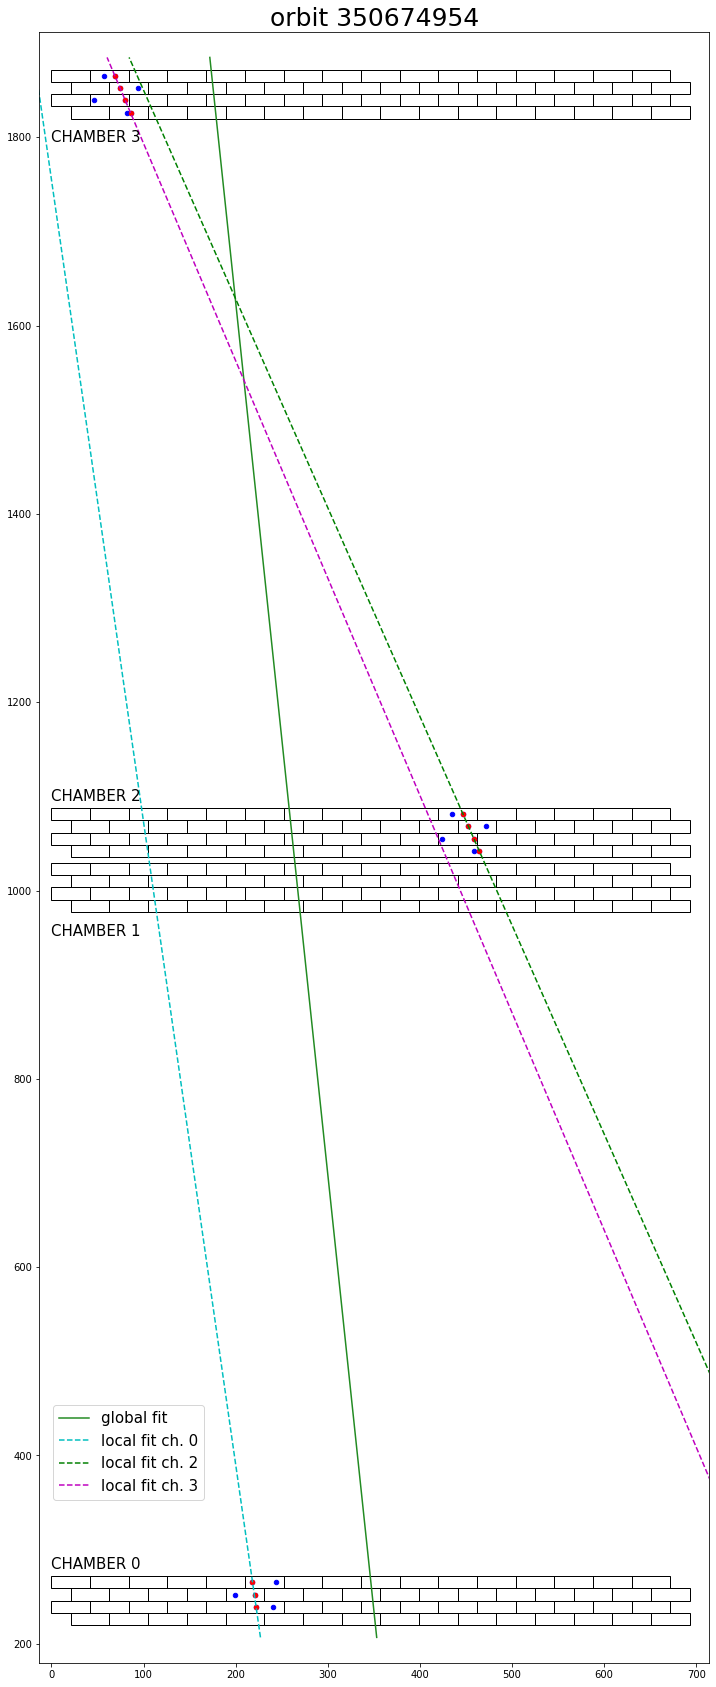

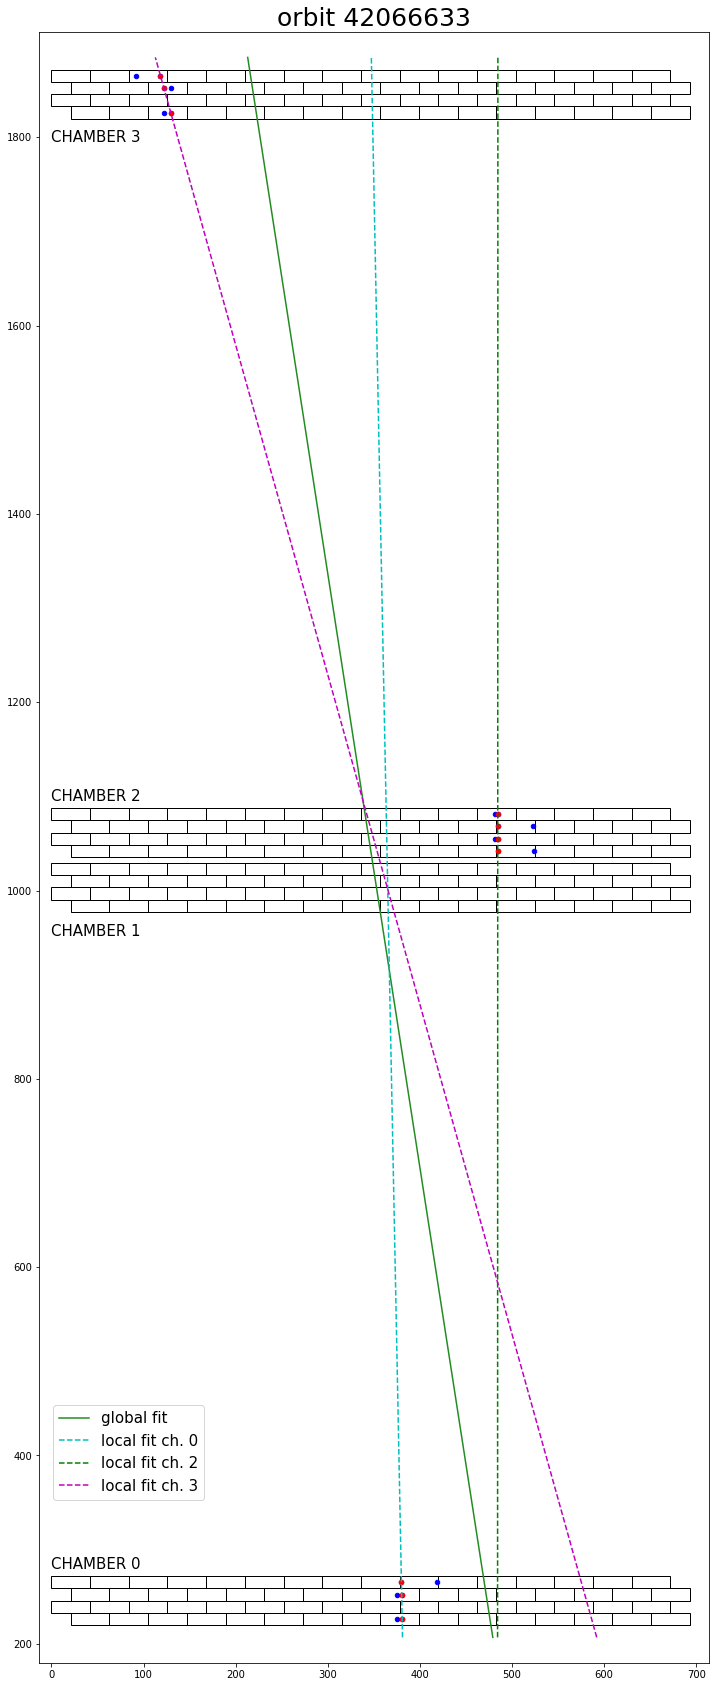

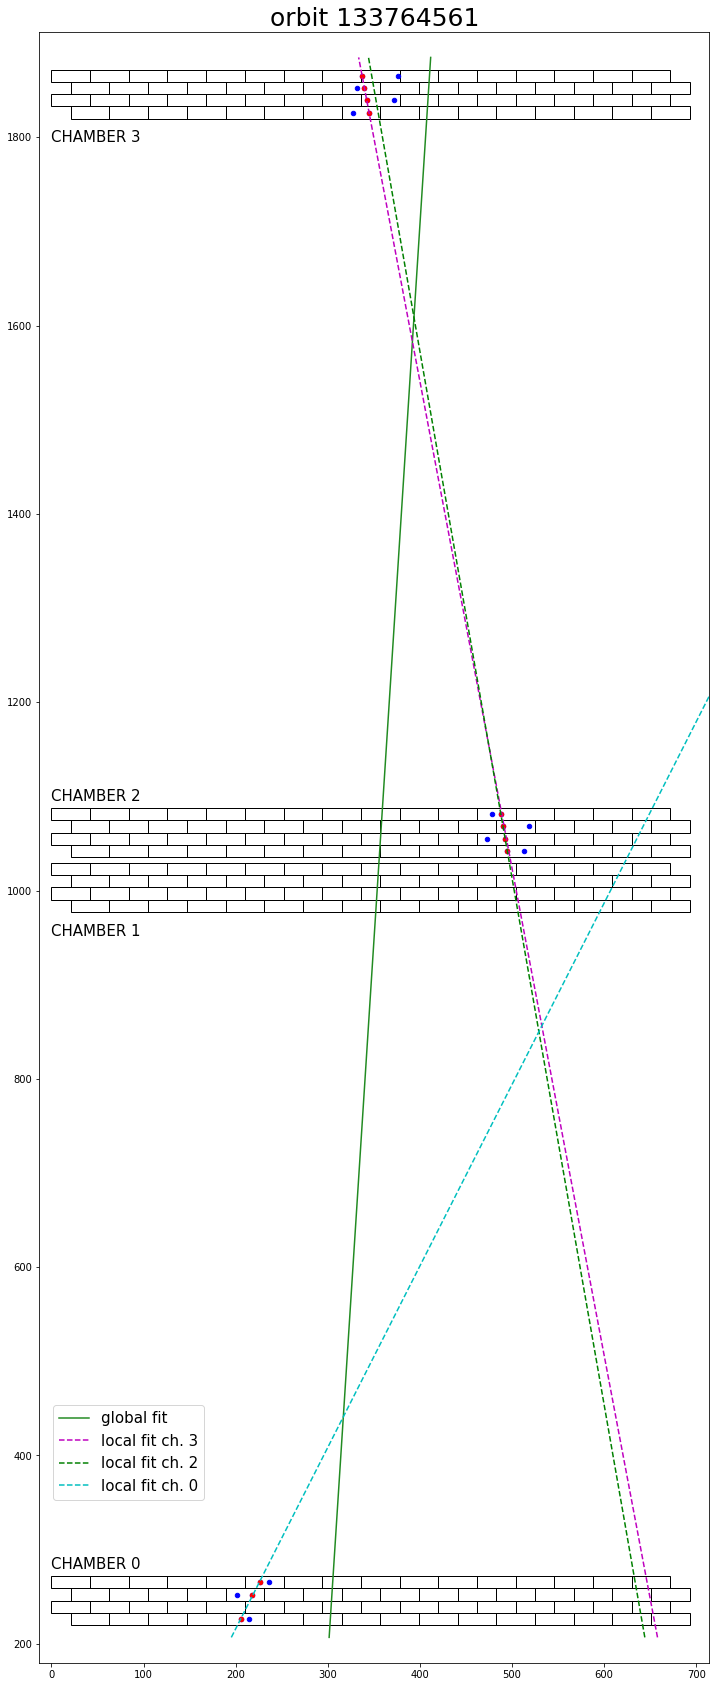

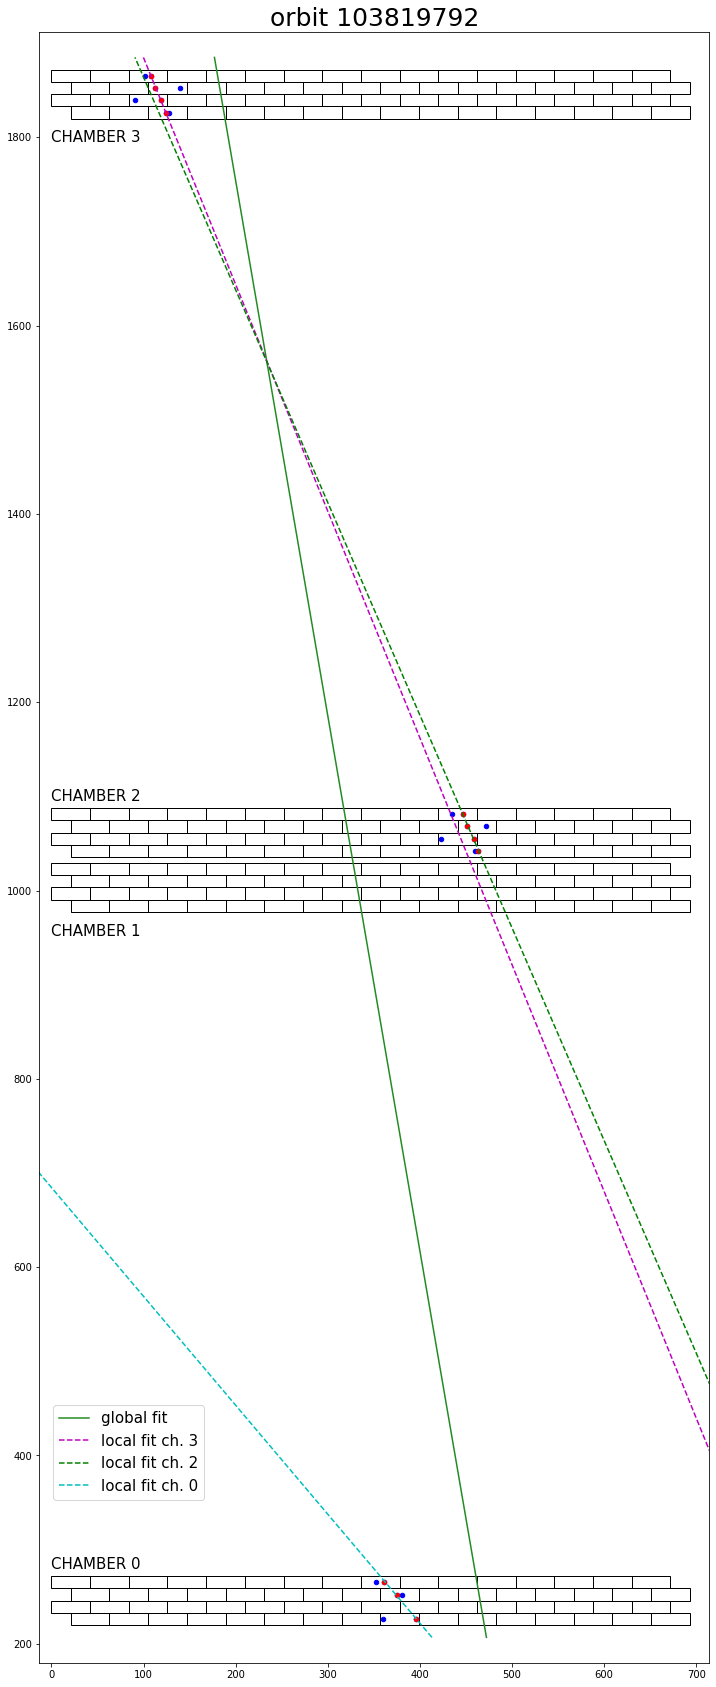

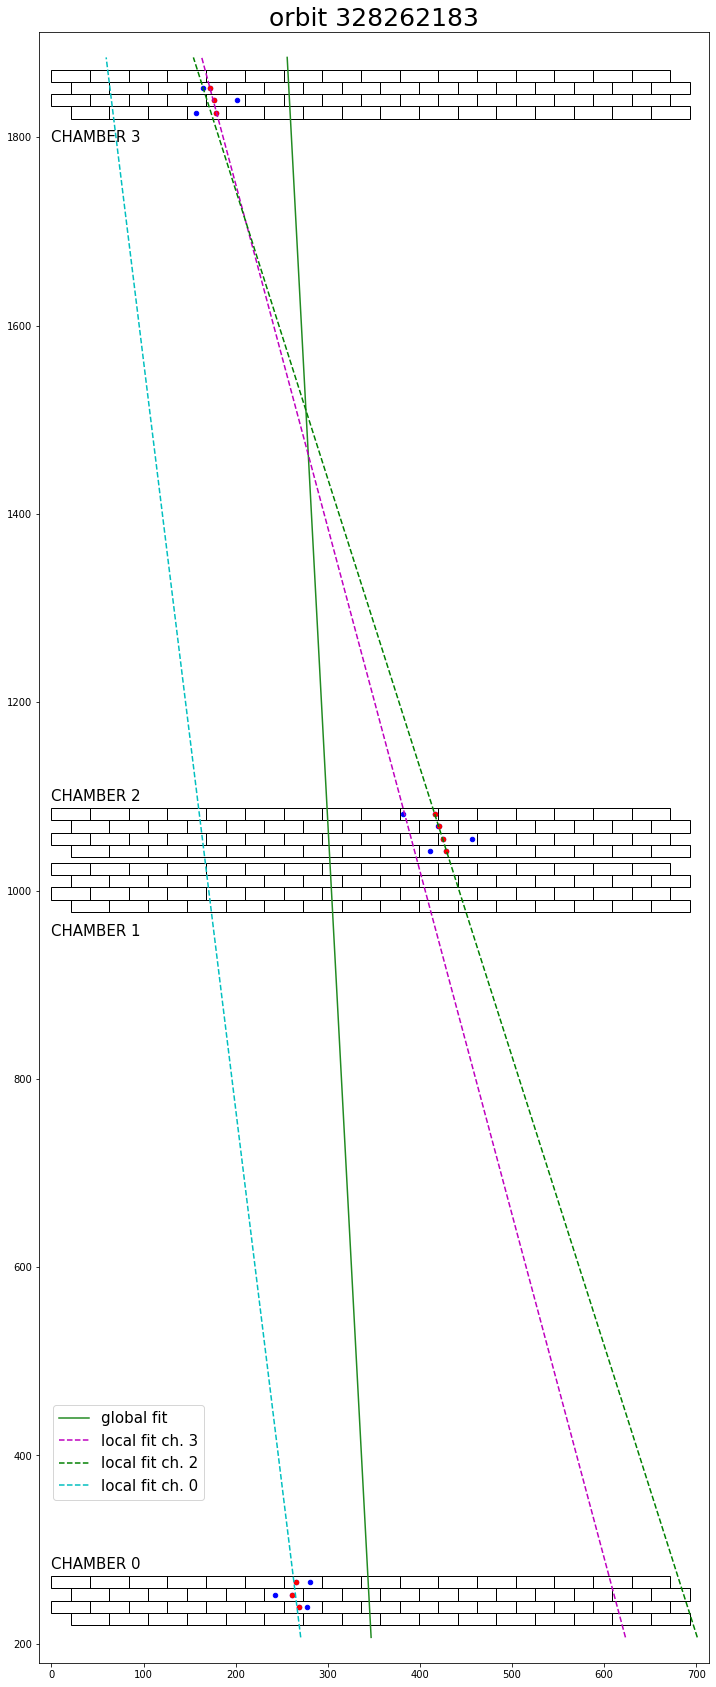

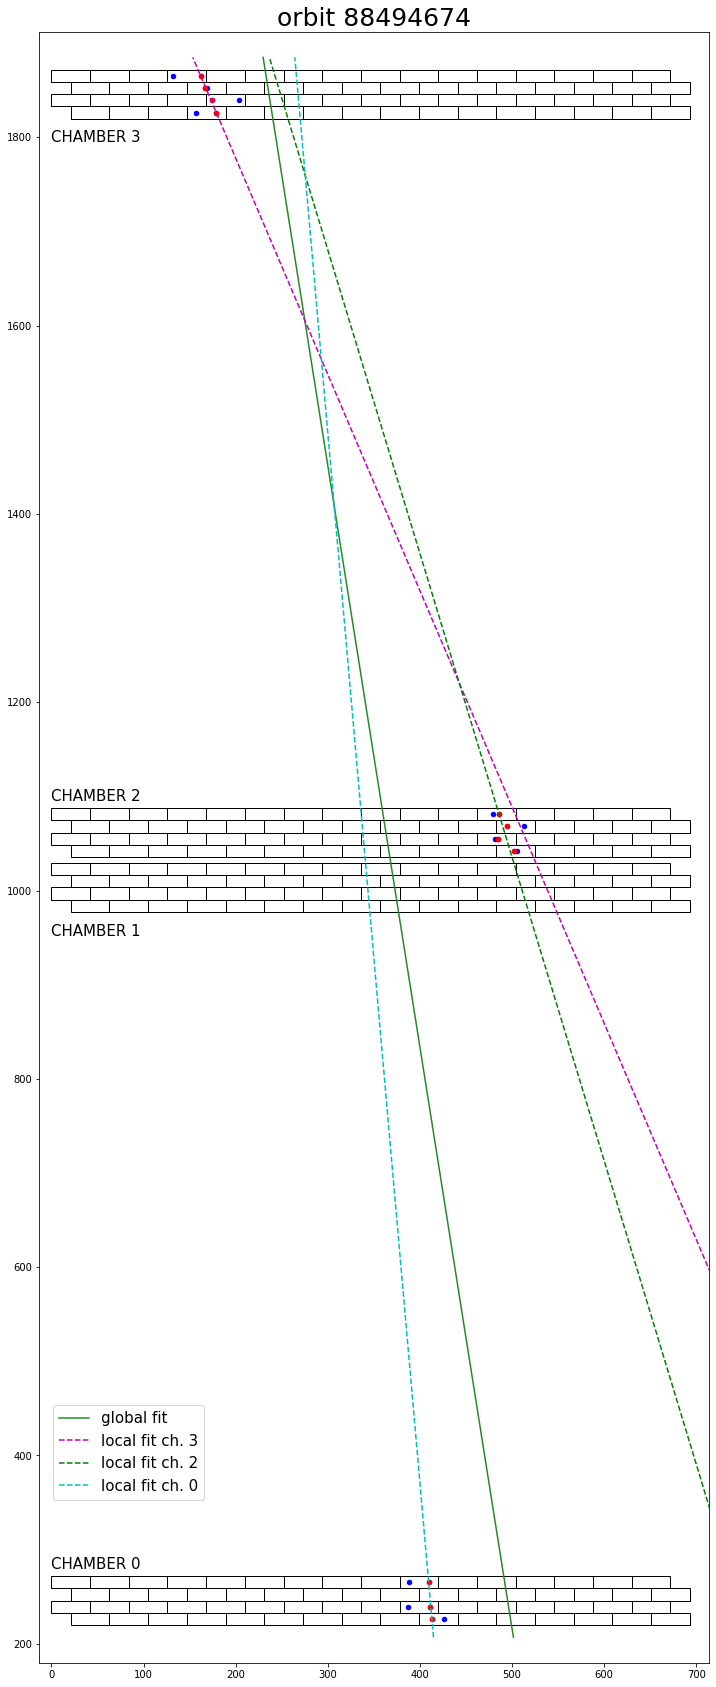

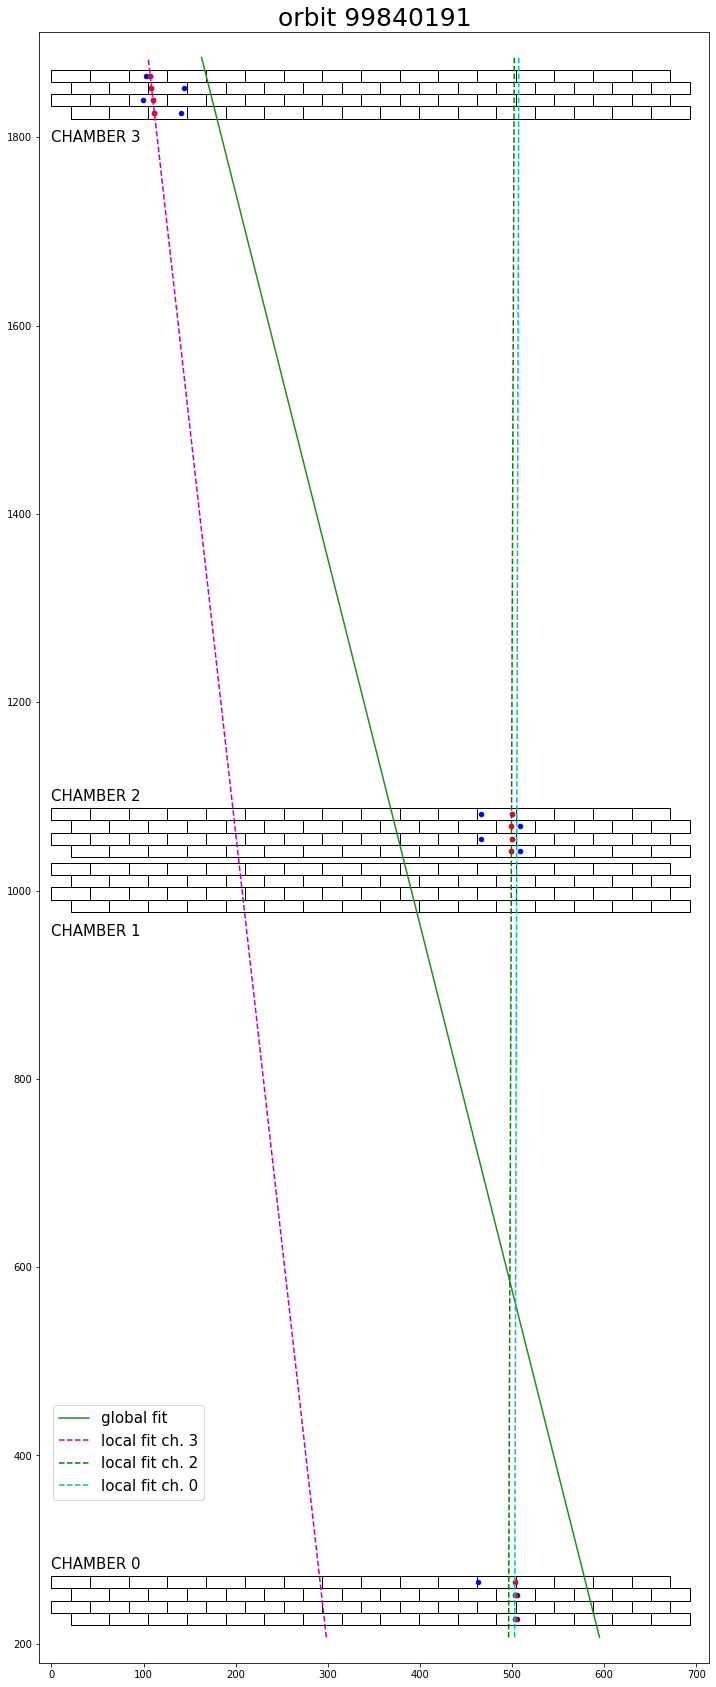

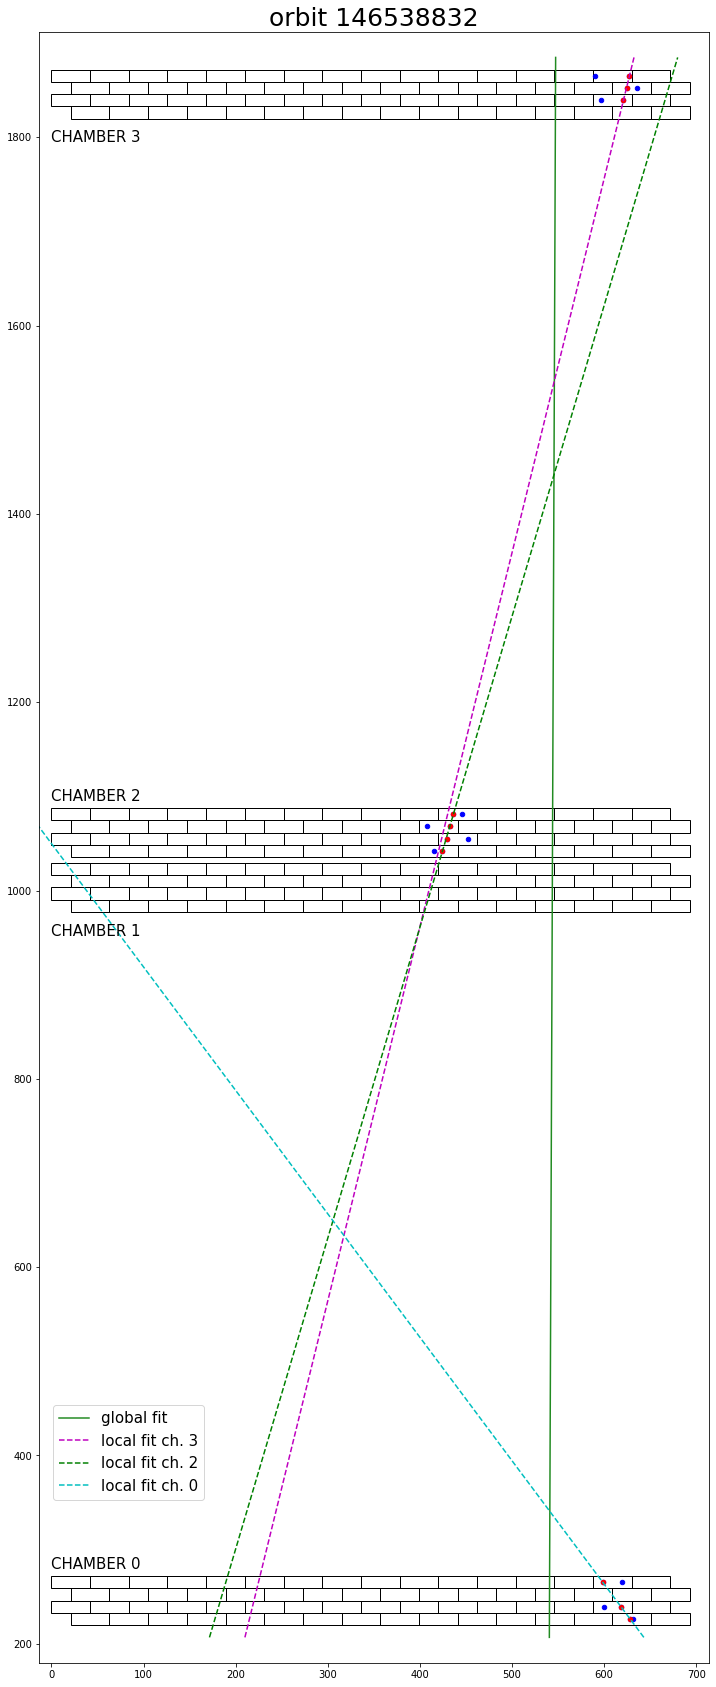

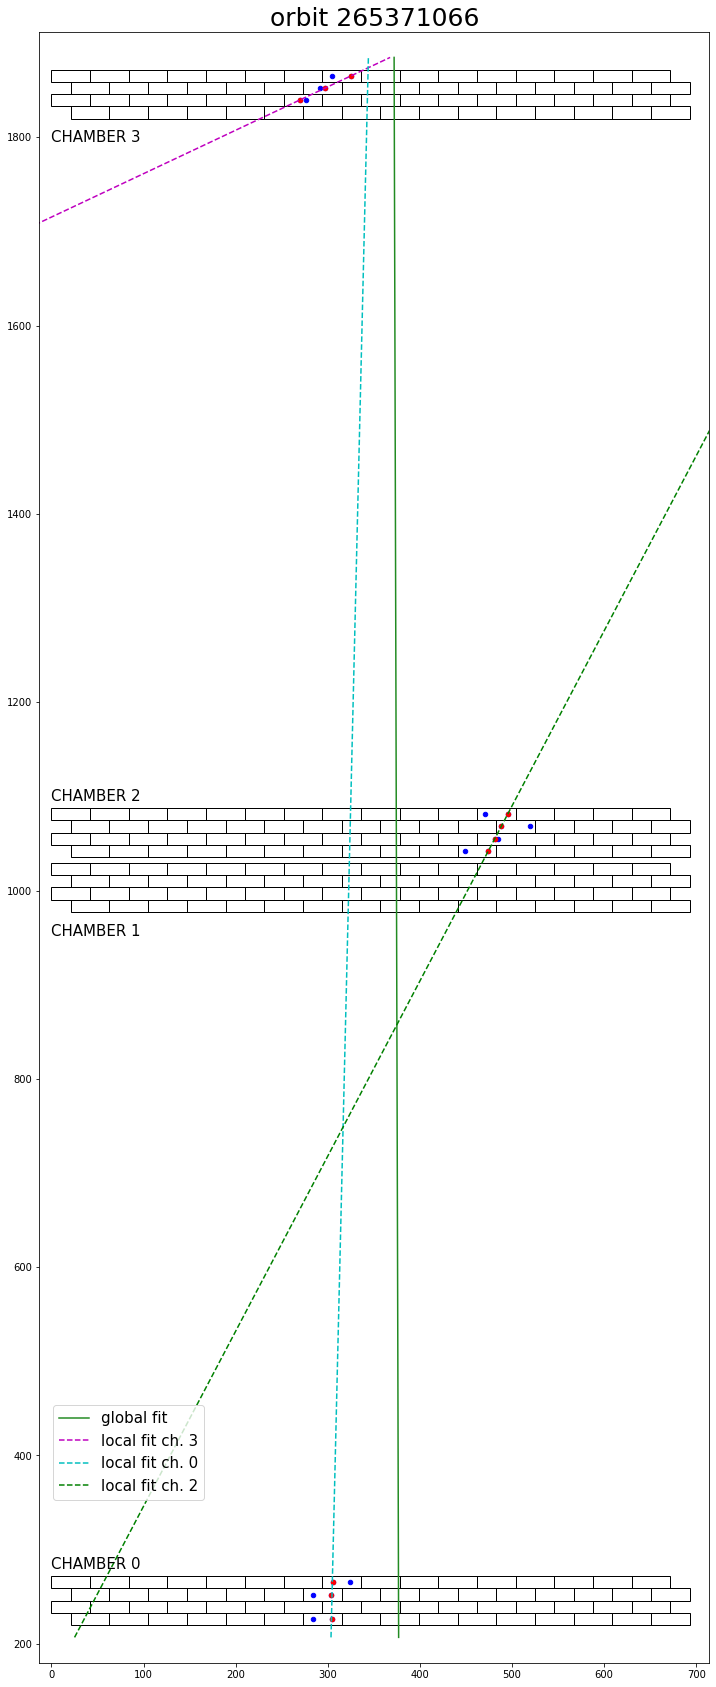

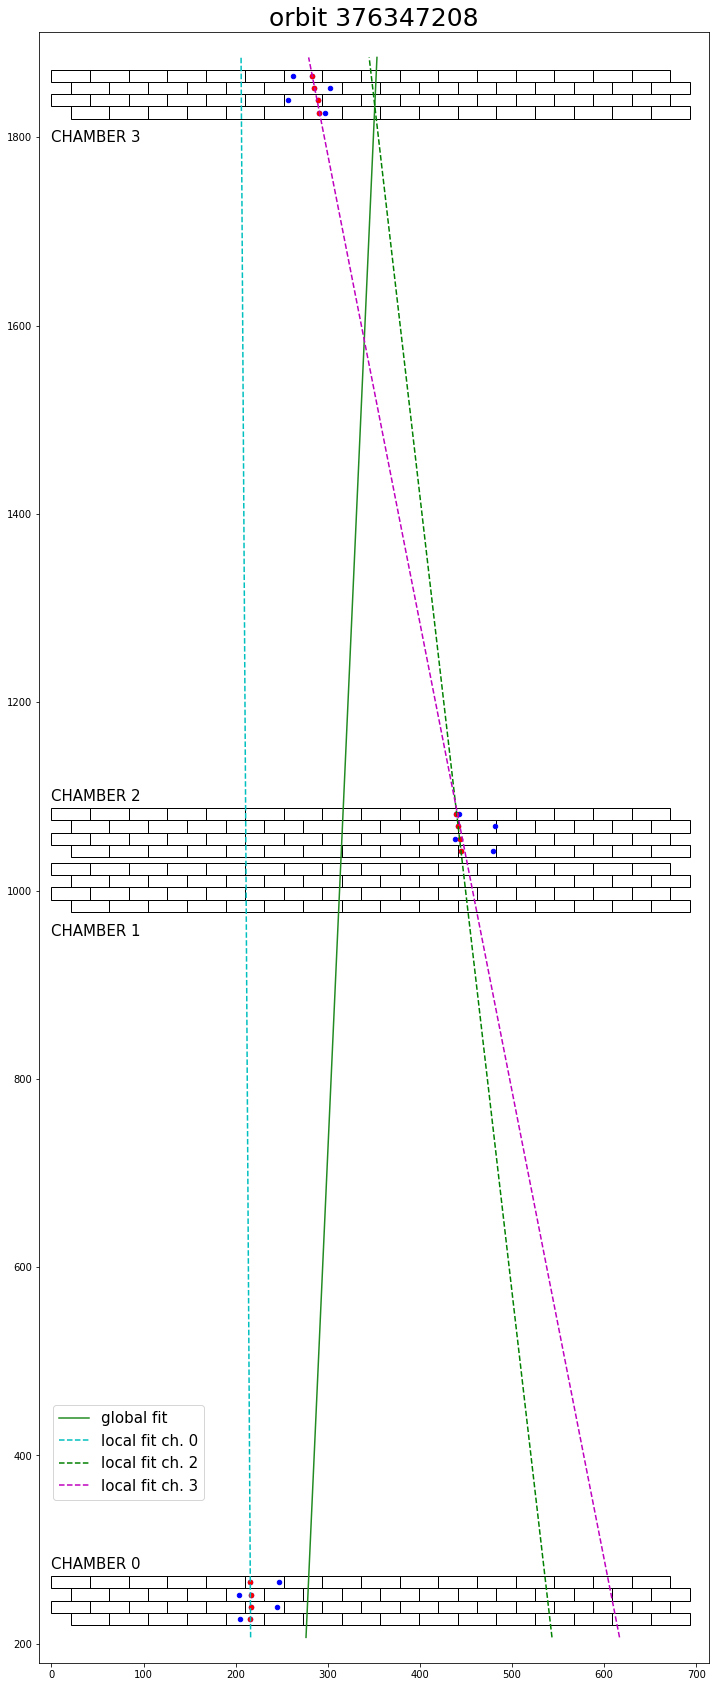

In [45]:
unique_orbits = [i.ORBIT for i in df12.select('ORBIT').distinct().orderBy(['sigma_global'], ascending = False).collect()]

for orbit in unique_orbits[:10]:
    plot_global_fit(df12[df12.ORBIT == orbit].toPandas())

In some special cases it seems that the most likely local fit (the one with the smallest $ssr$) is not the correct one. An example would be the event having *ORBIT* = 22160972, where there are two very good options for particle trajectory in *CHAMBER 0*, but the best real appears to be the one with the higher $ssr$ of the two. To correct this type of behavior and at the same time improve the estimation of the detector resolution (as will be shown below), an alternative algorithm for local and global fit has been developed. It will be discussed at the end of the notebook.

<AxesSubplot:title={'center':'orbit 22160972'}>

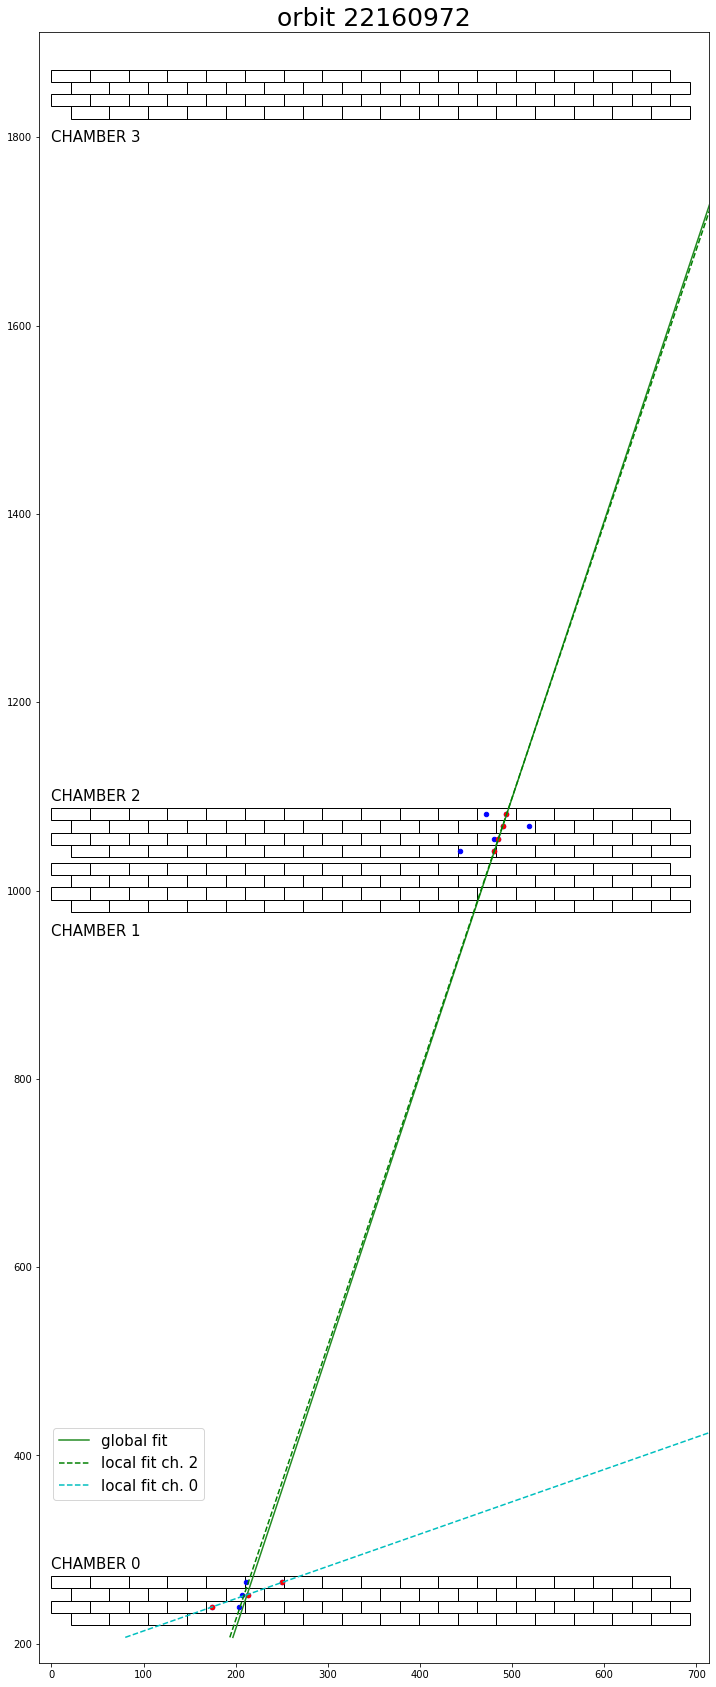

In [46]:
plot_global_fit(df12[df12.ORBIT == 22160972].toPandas())

## Angular resolution of the detector

The final stage of the analysis is the study of the angular resolution of the detectors.

The first step is to use the `atan()` function on the angular coefficients to retrieve the angle to the x-axis of the global and local fits. Since this function returns a negative angle if the angular coefficient is negative, a quantity of $\pi$ (180°) must be added to get the correct value. 

The angle that measures the correspondence between a local fit and the global one is the one in the figure. It can be calculated as the difference between the local and global angles.

![alt text](resolution_angle.png "Title")

In [47]:
df12 = df12.select('ORBIT','CHAMBER','m','m_global')

In [48]:
from pyspark.sql.functions import atan

df13 = df12.withColumn("angle_local", when((df12.m > 0), atan(df12.m))\
                                     .when((df12.m < 0), atan(df12.m) + np.pi))\
           .withColumn("angle_global", when((df12.m_global > 0), atan(df12.m_global))\
                                      .when((df12.m_global < 0), atan(df12.m_global) + np.pi))  

df13 = df13.withColumn("diff_angle", col("angle_local") - col("angle_global"))

The distribution of these values is then plotted considering the single chamber 2 and the set of all the chambers.

### Only CHAMBER 2

Filtering only events in chamber 2, the angle difference is converted in degrees for a better understanding.  

In [49]:
df14 = df13[df13.CHAMBER == 2]
diff_single = np.array(df14.select('diff_angle').distinct().collect()).flatten()

#diff_single = np.array(df14.select('ORBIT','diff_angle').distinct().drop('ORBIT').collect()).flatten()

diff_single = (diff_single*180)/np.pi

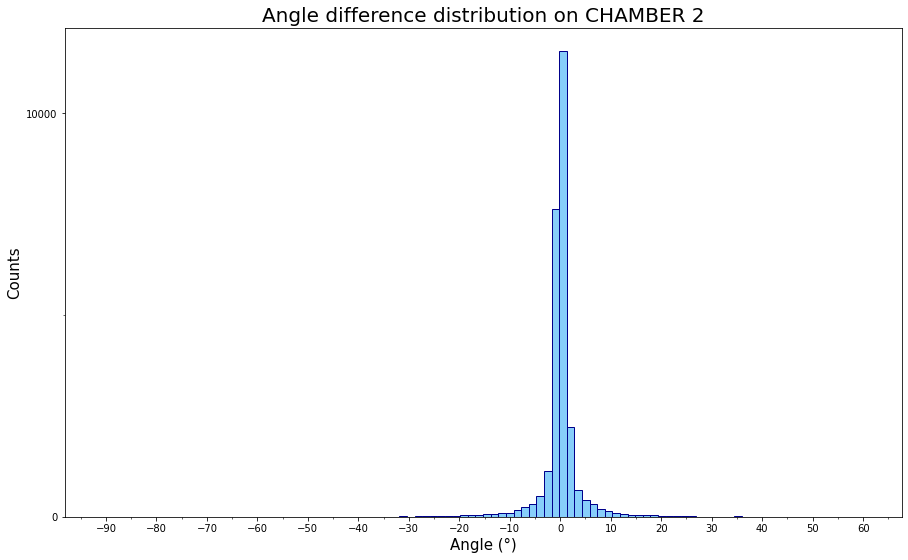

In [50]:
fig, ax = plt.subplots(figsize = (15, 9)) 
histogram = ax.hist(diff_single, bins = 100, color='lightskyblue', edgecolor="darkblue", alpha=1)

ax.set_xlabel('Angle (°)', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.set_title("Angle difference distribution on CHAMBER 2", fontsize=20)

ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(10000))
ax.yaxis.set_minor_locator(MultipleLocator(5000))

In [51]:
def round_list(list):
    rounded_list = []
    for i in list:
        rounded_list.append(np.round(i,3))
    return rounded_list

mean = np.mean(diff_single)
devstd = np.std(diff_single)
interval = [np.quantile(diff_single, 0.025), np.quantile(diff_single, 0.975)]
interval67 = [np.quantile(diff_single, (1 - 0.67)/2), np.quantile(diff_single, 1- (1 - 0.67)/2)]
quantile0 = (diff_single < 0).mean()

d = {'Values': [mean, devstd, round_list(interval), round_list(interval67), np.round(quantile0, 3)]}
chamber_2 = pd.DataFrame(data=d, index=[r'mean', r'devstd', r'95 % interval', r'67 % interval', r'quantile of the value 0']).round(3)
chamber_2

,Values
mean,0.089954
devstd,4.60119
95 % interval,"[-8.663, 8.623]"
67 % interval,"[-1.106, 1.313]"
quantile of the value 0,0.474


As can be seen, the angular difference distribution peaks around 0 and has quite large tails. The shape is almost certainly not Gaussian (the Gaussian fit is really bad) and resembles that of the Cauchy distribution.
Importantly, it is not possible to infer a specific distribution without any prior model for angular uncertainty.
The distribution is not exactly centered in 0 and the 67% interval is not symmetric with respect to the zero value, while the 95% seems to be more symmetric.
In any case, observing the quantiles, the deviation of the mean value from zero seems to be low enough.

### All the CHAMBERS

In [52]:
diff_all = np.array(df13.select('diff_angle').distinct().collect()).flatten()

#diff_all = np.array(df13.select('ORBIT','diff_angle').distinct().drop('ORBIT').collect()).flatten()

diff_all = (diff_all*180)/np.pi

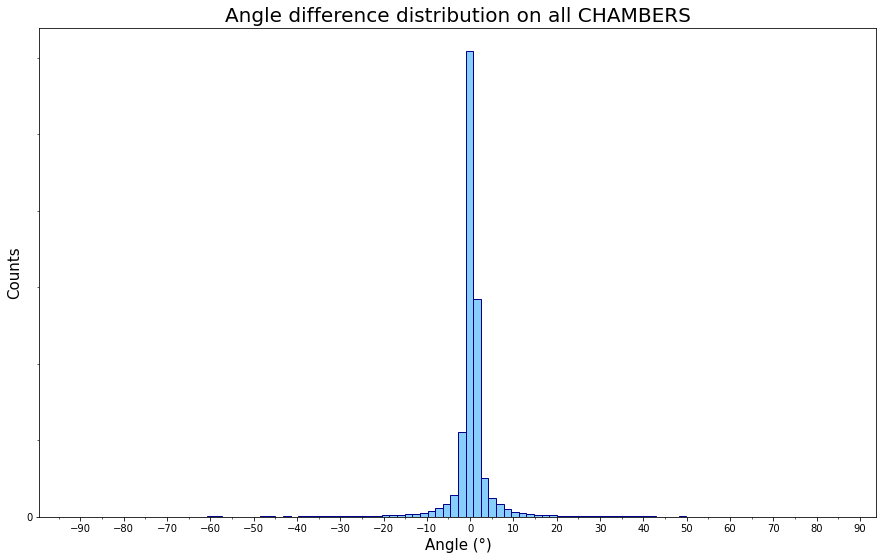

In [53]:
fig, ax = plt.subplots(figsize = (15, 9)) 
histogram = ax.hist(diff_all, bins = 100, color='lightskyblue', edgecolor="darkblue", alpha=1)

ax.set_xlabel('Angle (°)', fontsize=15)
ax.set_ylabel('Counts', fontsize=15)
ax.set_title("Angle difference distribution on all CHAMBERS", fontsize=20)

ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(100000))
ax.yaxis.set_minor_locator(MultipleLocator(5000))


In [54]:
mean = np.mean(diff_all)
devstd = np.std(diff_all)
interval = [np.quantile(diff_all, 0.025), np.quantile(diff_all, 0.975)]
interval67 = [np.quantile(diff_single, (1 - 0.67)/2), np.quantile(diff_single, 1- (1 - 0.67)/2)]
quantile0 = (diff_all < 0).mean()

d = {'Values': [mean, devstd, round_list(interval), round_list(interval67), np.round(quantile0, 3)]}
chamber_all = pd.DataFrame(data=d, index=[r'mean', r'devstd', r'95 % interval', r'67 % interval', r'quantile of the value 0']).round(3)


chamber_all

,Values
mean,0.22833
devstd,6.660772
95 % interval,"[-10.102, 10.525]"
67 % interval,"[-1.106, 1.313]"
quantile of the value 0,0.438


As in the case of chamber 2 only, the shape of the distribution is well defined, with a peak close to 0. However, it can be observed that the mean value differs more from 0 than in the case in which only chamber 2 is considered. Similarly, credibility intervals appear to be asymmetrical with respect to 0, but have greater symmetry around the mean value.
This could be due to lower reliability of the measurements of the external chambers compared to the central ones, or to a misalignment between the chambers.

From the available data only, however, it is not easy to determine whether the observed deviation is the result of some systematic error or only of a possible fluctuation: further investigations are needed.

<br>
<br>
<br>

Considering the 95% credibility interval as an estimate for the angular resolution (and this is an arbitrary choice), the following results are obtained:
- Considering only chamber 2, the resolution is about $ 8.6 ° $
- Considering all the chambers, the resolution is about $ 10.3 ° $

In [55]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 386.4248106479645 seconds ---


In [56]:
#sc.stop()

In [57]:
#spark.stop()

## PERFORMANCE ANALYSIS

We investigated how the performance change when varying separately:

- number of partitions
- number of cores per executor, number of executors, and memory per executor so that the number of cores used is always the same, the maximum, and the total memory used per worker is always 6.4 GB.

There is no real rule for fine-tuning these parameters: decisions may be based on the hardware available, but to have a definitive and quantitative answer it is necessary to investigate which configuration offers the best performance.

In literature, the suggested number of partitions is 3-4 times the number of available cores in the cluster for the application, and the ideal number of cores per executor is suggested to be around 5.

The total memory available per worker is estimated to be 6.8 GB. We decided to leave about 0.5 GB of memory for other possible VM operations and overheads.

The configurations considered were:
- 1 executor per worker, 4 cores per executor (so one executor per worker), 6.4 GB of memory per executor
- 2 executors per worker, 2 cores per executor, 3.2 GB of memory per executor
- 4 executors per worker, 1 core per executor, 1.6 GB of memory per executor
- 1, 2, 3, and 4 cores when considering only one worker with one executor

But first, the number of partitions was analyzed.
For each configuration, the following numbers of partitions were considered: 16, 32, 64, 128, and 256.

The overall processing time for the tested configurations is estimated with the `time.time()` Python function.

It has been chosen to use this method instead of estimating the time from the Spark UI as the Jupyter Notebook application and some parts of code purely in Python are used to actually obtain all the results, and we have therefore chosen to estimate the overall time that allows you to get all the results.
It has been estimated that the execution time thus calculated differs in excess of that calculated through Spark UI by a time interval between 45 seconds and 2 minutes, in proportion to the execution time.

For all tests, only one measure is considered, and the error on the measure is not provided: indeed, the data processing in extreme cases (e. g. only 2 cores used or only 2 partitions considered) can take a long time, and this makes difficult to take multiple measures using the same cluster configuration.

In cases where the same measurement has been repeated, a variation of at most 10 seconds was observed in the execution time.

<br>
<br>
<br>

The time measurements (in seconds) are shown below.

In [58]:
time_data_2work = pd.read_csv('times_spark_2w.txt')
time_data_2work

,exec/worker,cores/exec,memory/exec,partitions,time(s)
0,1,4,6.4,2,2177.458777
1,1,4,6.4,4,771.497691
2,1,4,6.4,8,535.792479
3,1,4,6.4,16,418.045867
4,1,4,6.4,32,410.905644
5,1,4,6.4,64,384.275448
6,1,4,6.4,128,389.332305
7,1,4,6.4,256,401.515952
8,2,2,3.2,16,438.251356
9,2,2,3.2,32,427.051498


In [59]:
time_data_1work = pd.read_csv('times_spark_1w.txt')
time_data_1work

,exec/worker,cores/exec,memory/exec,partitions,time(s)
0,1,4,6.4,64,523.716953
1,1,3,6.4,64,619.587757
2,1,2,6.4,64,872.807749
3,1,1,6.4,64,1620.145704


<br>
<br>
As can be seen in  the plot below, the best performance is given by the configuration consisting of 1 executor per worker, 4 cores per executor. This is also as close to 5 cores per executor as possible, which is considered the optimal configuration in literature.

Also, it can be observed that 64 and 128 partitions give the best performance. On the other hand, it can be observed that the execution time begins to increase when the number of partitions increases or decreases with respect to these values.
It is also noted that the value that leads to the best performance, 64, is 8 times the number of cores available for the application, and therefore differs from the values identified in the literature.
This could be due to the fact that, for partition values equal to 3-4 times the number of cores, the partitions may be too large in size to determine optimal processing in terms of performance.

In [60]:
partitions = [16, 32, 64, 128, 256]
time_1c = [463, 467, 428, 439, 498]
time_2c = [438, 427, 419, 424, 453]
time_4c = [418, 411, 384, 389, 402]

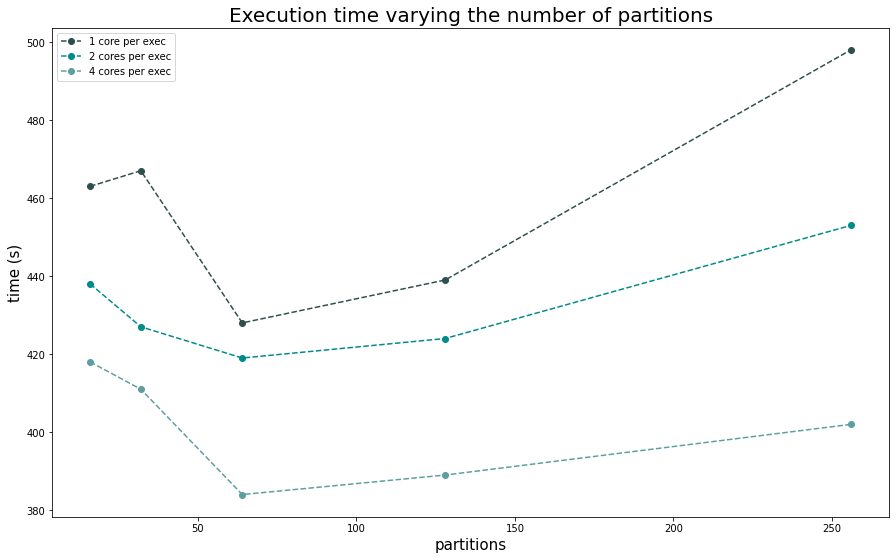

In [61]:
fig, ax = plt.subplots(figsize = (15, 9)) 
ax.plot(partitions, time_1c, label = "1 core per exec", color = "darkslategray", marker = 'o', ls = '--')
ax.plot(partitions, time_2c, label = "2 cores per exec", color = "darkcyan", marker = 'o', ls = '--')
ax.plot(partitions, time_4c, label = "4 cores per exec", color = "cadetblue", marker = 'o', ls = '--')
ax.set_title('Execution time varying the number of partitions', fontsize = 20)
ax.set_xlabel('partitions', fontsize = 15)
ax.set_ylabel('time (s)', fontsize = 15)
ax.legend()

The same discussed result can be observed in the following plot, which shows the execution time as a function of the number of executors per worker for the five inspected cases of partitions number.

In [62]:
execu = [1,2,4]
time16p = [418, 438, 463]
time32p = [411, 427, 467]
time64p = [384, 419, 428]
time128p = [389, 424, 439]
time256p = [402, 453, 498]

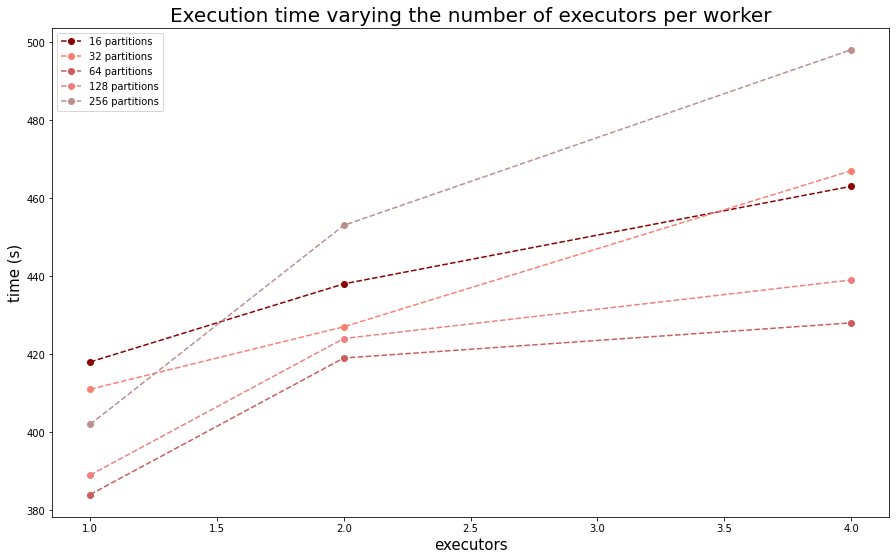

In [63]:
fig, ax = plt.subplots(figsize = (15, 9)) 
ax.plot(execu, time16p, label = "16 partitions", color = "darkred", marker = 'o', ls = '--')
ax.plot(execu, time32p, label = "32 partitions", color = "salmon", marker = 'o', ls = '--')
ax.plot(execu, time64p, label = "64 partitions", color = "indianred", marker = 'o', ls = '--')
ax.plot(execu, time128p, label = "128 partitions", color = "lightcoral", marker = 'o', ls = '--')
ax.plot(execu, time256p, label = "256 partitions", color = "rosybrown", marker = 'o', ls = '--')
ax.set_title('Execution time varying the number of executors per worker', fontsize = 20)
ax.set_xlabel('executors', fontsize = 15)
ax.set_ylabel('time (s)', fontsize = 15)
ax.legend()

A further inspection of what happens when the number of partitions is decreased (so reducing the degree of parallelism) was carried out using that configuration.

It should be noted that this can lead to spilling, i.e. to the fact that the partition is too large to fit in the RAM of the executor, so the data is written (spilled) to disk and then read again.

The following plot shows the execution time varying the number of partitions between 2 and 256, for the configuration of 1 executor per worker, 4 cores per executor in two cases: memory per executor 6.4 GB and 4.8 GB.

When considering the case of 2 partitions (almost no parallelization), it can be observed that the 6.4 GB per executor trial has significantly worse performance than the corresponding trial with less memory.

This could be due to the fact that too little memory was available for other VM processes and overhead or that partitions were too large.

In fact, using 6.4GB of memory and a number of partitions less than or equal to 8, we sometimes get a warning about a lost executor and missing an output location for the shuffle partition: the proposed solutions to this are decreasing memory per executor (thus allowing more memory for overhead and other VM processes) and increasing the number of partitions.

However, it can be observed that when the number of partitions is increased, the execution time is similar.

In [64]:
partitions = [2, 4, 8, 16, 32, 64, 128, 256]
time_64 = [2177, 771, 535, 418, 411, 384, 389, 402]
time_48 = [1300, 766, 539, 427, 416, 390, 390, 400]

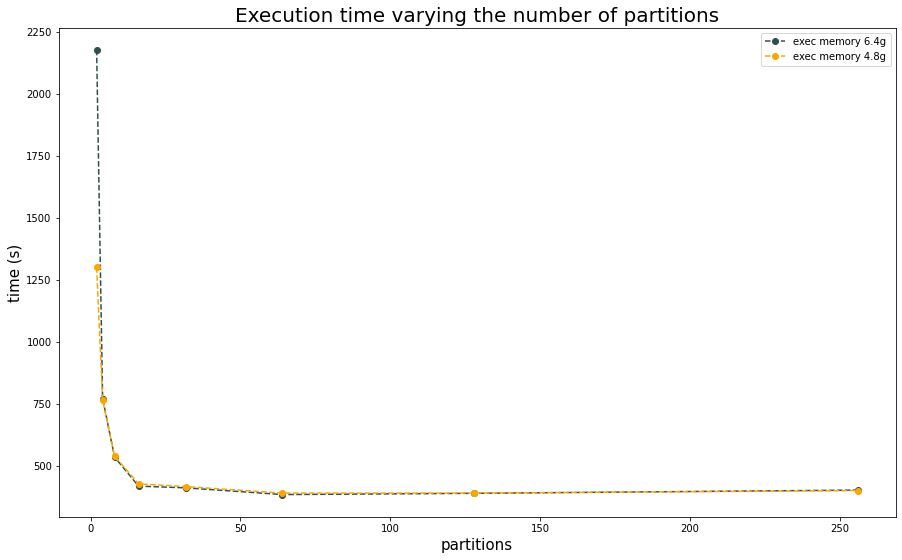

In [65]:
fig, ax = plt.subplots(figsize = (15, 9)) 
ax.plot(partitions, time_64, label = "exec memory 6.4g", color = "darkslategray", marker = 'o', ls = '--')
ax.plot(partitions, time_48, label = "exec memory 4.8g", color = "orange", marker = 'o', ls = '--')
ax.set_title('Execution time varying the number of partitions', fontsize = 20)
ax.set_xlabel('partitions', fontsize = 15)
ax.set_ylabel('time (s)', fontsize = 15)
ax.legend()

We also wanted to study performance as a function of the degree of parallelism. To do this, we started the cluster with only the master and one worker and varied the number of cores between 1 and 4, always considering one executor with 6.4GB of memory and 64 partitions.

We observe that the performance improves as the number of cores increases while keeping all the other parameters fixed: this proves and highlights the power of distributed processing.

In [3]:
cores = [1,2,3,4]
time64 = [1620, 873, 620, 524]
speedups = np.asarray([time64[0]/time64[i] for i in range(len(time64))])

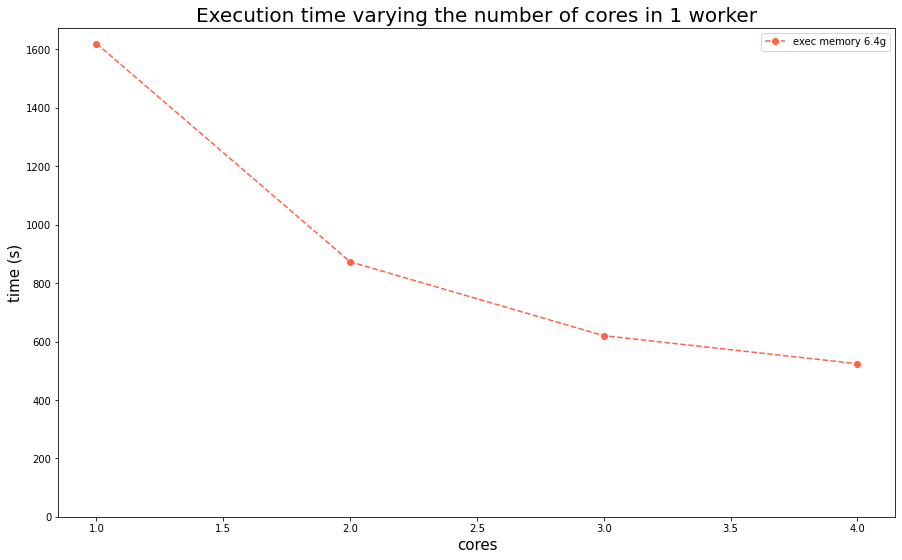

In [67]:
fig, ax = plt.subplots(figsize = (15, 9)) 
ax.plot(cores, time64, label = "exec memory 6.4g", color = "tomato", marker = 'o', ls = '--')
ax.set_title('Execution time varying the number of cores in 1 worker', fontsize = 20)
ax.set_xlabel('cores', fontsize = 15)
ax.set_ylabel('time (s)', fontsize = 15)
ax.set_ylim(bottom=0)
ax.legend()

So, as already observed, it is possible to speed up the computation time by adding more cores, and therefore processing the data in parallel. Part of the processing, however, will always have to be performed serially, no matter the available resources.
This implies that the fraction of parallelizable processing is never 1.

The speedup obtained by using n computing units instead of one, Speedup(n), is defined as the ratio between the execution time of one CU and the parallel execution time of n CUs.

The mathematical law that describes speedup as a function of the parallelizable fraction p and the number of CU is called Amdahl's law.

Having already measured the execution times as the number of cores changes, it was decided to calculate the corresponding speedups and to perform a fit to verify if the results found actually follow Amdahl's law.

The fit determines that, for our code, the fraction of parallelizable processing is approximately 0.9.It was decided not to analyze the goodness of the fit. For each of the different configurations only one measurement was obtained, of which the error was not considered. This leads the fit to be a qualitative indication rather than a rigorous estimate of the parallelizable part of processing.

fraction of parallelizable processing:  0.909


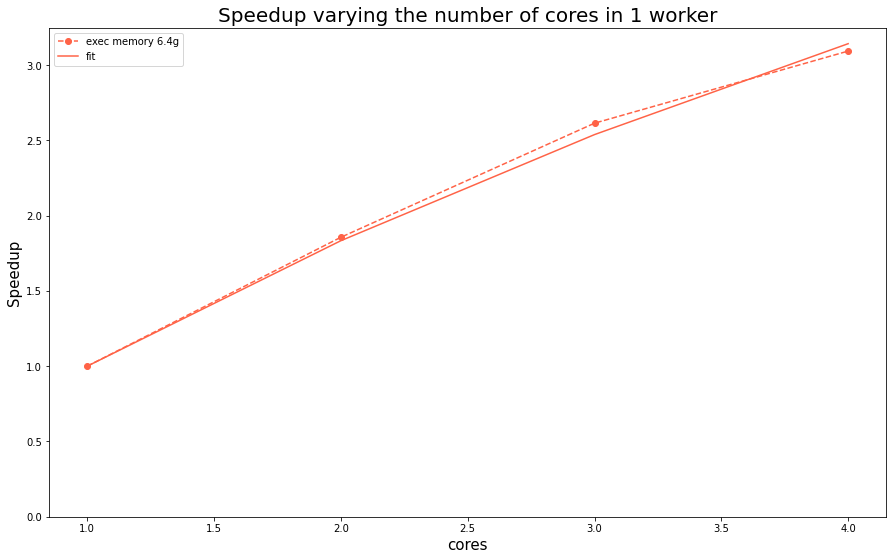

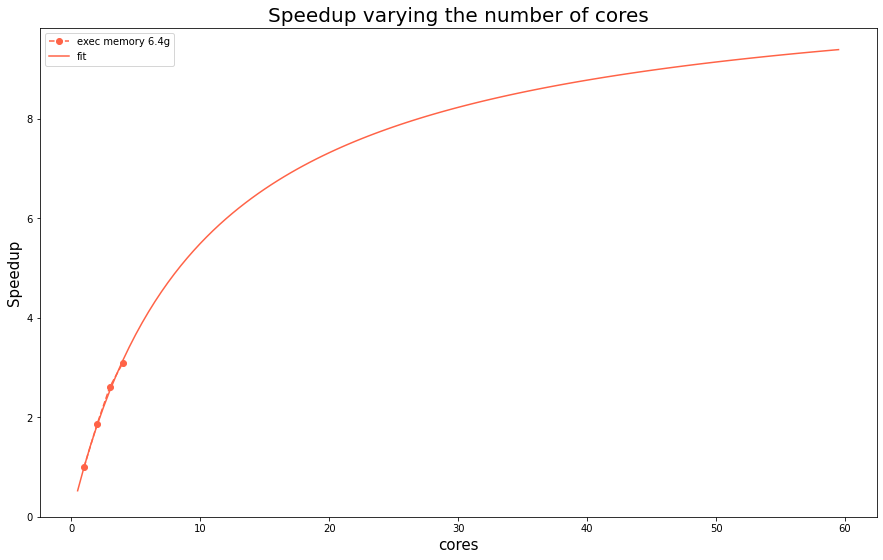

In [4]:
from scipy.optimize import curve_fit
def func(n, p):
    return 1 /((1 - p) + p/n)

popt, pcov = curve_fit(func, cores, speedups, p0=[0.9])
print('fraction of parallelizable processing: ', np.round(popt[0], 3))

fig, ax = plt.subplots(figsize = (15, 9)) 
ax.plot(cores, speedups, label = "exec memory 6.4g", color = "tomato", marker = 'o', ls = '--')
ax.plot(cores, func(cores, *popt), label = 'fit', color = 'tomato')
ax.set_title('Speedup varying the number of cores in 1 worker', fontsize = 20)
ax.set_xlabel('cores', fontsize = 15)
ax.set_ylabel('Speedup', fontsize = 15)
ax.set_ylim(bottom=0)
ax.legend()

fig, ax = plt.subplots(figsize = (15, 9)) 
ax.plot(cores, speedups, label = "exec memory 6.4g", color = "tomato", marker = 'o', ls = '--')
ax.plot(np.arange(0.5, 60, 0.5), func(np.arange(0.5, 60, 0.5), *popt), label = 'fit', color = 'tomato')
ax.set_title('Speedup varying the number of cores', fontsize = 20)
ax.set_xlabel('cores', fontsize = 15)
ax.set_ylabel('Speedup', fontsize = 15)
ax.set_ylim(bottom=0)
ax.legend()

<br>
<br>
<br>
From the analysis performed it can be concluded that the best configuration corresponds to two workers each with an executor and four cores per executor, and a number of partitions of about 64.
<br>
<br>
<br>

## Comments on count and persist

### Count

A `count()` is performed after `persist()` in the code, both times. This is beneficial mainly when the first persist is called, leading to an execution time improvement of about 30s (with our best cluster configuration).
When not performing a `count()`, indeed, the time elapsed up to the `show()` action decreases, but the time to execute the subsequent `collect()` triplicates, making the gain of not performing the `count()` vanish.

The second `count()` does not actually change the execution time.

### Persist
A `persist()` was tried after the `toDF()` action, in order to avoid to perform it again when other actions are applied further down.

With our best configuration of the cluster, this led to a speed up of approximately 50s without subsequently applying a `count()` action and 50s applying it.
It is to note, however, that this implies caching the whole unprocessed dataset, and indeed the size in memory is approximately 1GB.

We chose not to apply the persist since the advantage is due to the possibility of caching the entire dataset, that in our case is small. For larger datasets, however, the option to persist is not feasible.

## Conclusions

In this project we were able to complete the processing of the initial data set in order to calculate physical quantities such as the angular resolution of the detector.

This was possible by parallelizing all calculations through the Apache Spark framework, which speeded up the entire data processing.

Using this framework it was also possible to study the different characteristics of the parallelized system, fine-tuning a set of parameters that included the number of executors, the number of partitions and the number of cores.
In conclusion, with this work it was possible to understand the power of distributed computing applied to a data processing problem.

## Appendix: advanced fit algorithm

In this section, we investigate a proposal for local and global fit which does not rely only on $ssr$. One of the problems in taking only the $x_l$-$x_r$ combination with lower $ssr$ in the local fit is that there could exist two or more optimal solutions with very similar $ssr$ values. In that case, we lose the information about other optimal options, which could guarantee, a priori, a better global fit. The updates we are going to develop are the following:

-  In the local fit, among all the $x_l$-$x_r$ combinations, the two with lower $ssr$ are taken, keeping track also of the different resulting $m$ and $q$. Columns will be called $final \_ x1$, $m1$, $q1$, $final \_ x2$, $m2$, $q2$.
-  In the global fit, all possible combinations between $final \_ x1$ and $final \_ x2$ for all the chambers are tried (at most 8), keeping at the end the one with smaller $ssr\_global$.

The modified functions are called `local_fit_advanced` and `global_fit_advanced`, they can be inserted into the notebook with some careful adjustments to the dataset columns. From the point of view of the performances, the downside is that the complexity of these algorithms is higher, the computation time is about 440 s against 384 s of the standard algorithm. However, the advantage is that a better estimate for the detector resolution can be achieved. Results from this update lead to $\pm 8°$ and $\pm 9°$ as 95 % interval for the case with only *CHAMBER* 2 and the case with all the chambers.

In [69]:
def local_fit_advanced(group):
    sort_index = np.argsort(group['LAYER'])
    sort_x_c = np.array(group.x_c.values)[sort_index] # np.array
    if (group['LAYER'].nunique() > 2) and (group['LAYER'].nunique() == group.shape[0]) and (not (any(np.abs(np.diff(sort_x_c)) > (L/2)))):
    #
        
        xl_val = np.asarray(group.x_l.values)

        xr_val = np.asarray(group.x_r.values)
        
        y = np.asarray(group.z)
        
        n = group.shape[0]

        l = [np.asarray([xl_val[i],xr_val[i]]) for i in range(n)]

        if n == 3:
            comb = np.array(np.meshgrid(l[0], l[1], l[2])).T.reshape(-1, n)
        if n == 4:
            comb = np.array(np.meshgrid(l[0], l[1], l[2], l[3])).T.reshape(-1, n)

        top_score = 100000 
        final_i = 0
        m_list = np.zeros(len(comb)) # keeping track of all the m
        q_list = np.zeros(len(comb)) # keeping track of all the q
        score = np.zeros(len(comb)) # keeping track of all the scores

        for i in range(0,len(comb)):

            x=comb[i]
            y=y
            z,res,_,_,_ = np.polyfit(y, x, 1,full=True)

            score[i] = res
            m_list[i] = 1/z[0]
            q_list[i] = -z[1]/z[0]
               
        order = np.argsort(score)
        top_index = order[0] # index of the combination with lower ssr
        semitop_index = order[1] # index of the combination with second lower ssr

        group['final_x1'] = comb[top_index]
        group['m1'] = np.repeat(m_list[top_index], group.shape[0])
        group['q1'] = np.repeat(q_list[top_index], group.shape[0])
        group['sigma1'] = np.repeat(np.sqrt(score[top_index]/(n-2)), group.shape[0]) # a posterior sigma 
        
        group['final_x2'] = comb[semitop_index]
        group['m2'] = np.repeat(m_list[semitop_index], group.shape[0])
        group['q2'] = np.repeat(q_list[semitop_index], group.shape[0])
        group['sigma2'] = np.repeat(np.sqrt(score[semitop_index]/(n-2)), group.shape[0]) # a posterior sigma 
        
        return group
    
    else:
        
        return pd.DataFrame({
    'ORBIT': [-1],
    'CHAMBER': [-1],
    'LAYER': [-1],
    'CHAN': [-1],
    'x_c': [-1],
    'x_l': [-1],
    'x_r': [-1],
    'z': [-1],
    'final_x1': [-1],
    'm1': [-1],
    'q1': [-1],
    'sigma1': [-1],
    'final_x2': [-1],
    'm2': [-1],
    'q2': [-1],
    'sigma2': [-1]
    
    })

In [70]:
def global_fit_advanced(group):
    
    N = group['CHAMBER'].nunique()
    
    if N > 1:
        
        n = group.shape[0]
        l = []
        ly = []
        
        chamber = group['CHAMBER'].to_numpy()
        _, idx = np.unique(chamber, return_index=True)
        
        for ch in chamber[np.sort(idx)]:
            sub = group[group.CHAMBER == ch]
            final_x1 = sub.final_x1.to_numpy()
            final_x2 = sub.final_x2.to_numpy()
            y = sub.z.to_numpy()
            l.append(np.array([final_x1, final_x2]))
            ly.append(y)
                 
        comb = []
        
        if N == 3:
            for i in l[0]:
                for j in l[1]:
                    for k in l[2]:
                        comb.append(np.concatenate((i,j,k)))
            y = np.concatenate((ly[0], ly[1], ly[2]))
            
        if N == 2:
            for i in l[0]:
                for j in l[1]:
                    comb.append(np.concatenate((i,j)))
            y = np.concatenate((ly[0], ly[1]))
            
        top_score = 100000000
        final_i=0
        mg=0
        qg=0
        
        for i in range(0,len(comb)):
            xb = comb[i]
            z,score,_,_,_ = np.polyfit(y, xb, 1,full=True)

            if score<top_score:

                final_i = i
                mg = 1/z[0]
                qg = -z[1]/z[0]
                top_score = score
        
        group['final_traj'] = comb[final_i] # le m corrispondenti a questa combinazioneq
        group['m_global'] = np.repeat(mg, n)
        group['q_global'] = np.repeat(qg, n)
        group['sigma_global'] = np.repeat(np.sqrt(top_score/(n-2)), n) # a posterior sigma
        
        binm = []
        for i in range(N):
            binm.append(final_i%2)
            final_i = np.floor(final_i/2)
        binm = binm[::-1]
        
        ml = []
        ql = []
        for i, ch in enumerate(chamber[np.sort(idx)]):
            sub = group[group.CHAMBER == ch]
            m1 = sub.m1.to_numpy()
            m2 = sub.m2.to_numpy()
            q1 = sub.q1.to_numpy()
            q2 = sub.q2.to_numpy()
            if binm[i] == 0:
                ml.append(m1)
                ql.append(q1)
            else:
                ml.append(m2)
                ql.append(q2)
        
        if N == 3:
            final_m = np.concatenate((ml[0], ml[1], ml[2]))
            final_q = np.concatenate((ql[0], ql[1], ql[2]))
            
        if N == 2:
            final_m = np.concatenate((ml[0], ml[1]))
            final_q = np.concatenate((ql[0], ql[1]))
            
        group['final_m'] = final_m 
        group['final_q'] = final_q
        
        return group
    
    else:
        
        return pd.DataFrame({
    'ORBIT': [-1],
    'CHAMBER': [-1],
    'LAYER': [-1],
    'CHAN': [-1],
    'x_c': [-1],
    'x_l': [-1],
    'x_r': [-1],
    'z': [-1],
    'final_x1': [-1],
    'm1': [-1],
    'q1': [-1],
    'sigma1': [-1],
    'final_x2': [-1],
    'm2': [-1],
    'q2': [-1],
    'sigma2': [-1],
    'final_traj': [-1],    
    'final_m': [-1],
    'final_q': [-1],
    'm_global': [-1],
    'q_global': [-1],
    'sigma_global': [-1]
    
    })

![alt text](advanced_fit1.png "Title")

![alt text](advanced_fit2.png "Title")